In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import glob

In [2]:
filenames = glob.glob('Datathon*.csv')

In [3]:
pre_dat = pd.DataFrame({})
for ind, filename in enumerate(filenames):
    print(ind)
    tmp_dat = pd.read_csv(filename)
    pre_dat = pre_dat.append(tmp_dat)    
pre_dat.columns = ['BET_ID', 'BET_TRANS_ID', 'MATCH_BET_ID', 'ACCOUNT_ID',
       'COUNTRY_OF_RESIDENCE_NAME', 'PARENT_EVENT_ID', 'EVENT_ID', 'MATCH',
       'EVENT_NAME', 'EVENT_DT', 'OFF_DT', 'BID_TYP', 'STATUS_ID',
       'PLACED_DATE', 'TAKEN_DATE', 'SETTLED_DATE', 'CANCELLED_DATE',
       'SELECTION_NAME', 'PERSISTENCE_TYPE', 'BET_PRICE', 'PRICE_TAKEN',
       'INPLAY_BET', 'BET_SIZE', 'PROFIT_LOSS']
peek_dat = pd.read_csv('DSMDatathon_samplefile.txt', sep='\t')
pre_dat = peek_dat.append(pre_dat)

0
1

/Users/feizhan/miniconda/envs/py3_env/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
/Users/feizhan/miniconda/envs/py3_env/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)



2
3
4


In [4]:
pre_dat.loc[:, 'BID_TYP'] = pre_dat.loc[:, 'BID_TYP'].str.strip(' ')
pre_dat.loc[:, 'STATUS_ID'] = pre_dat.loc[:, 'STATUS_ID'].str.strip(' ')

In [6]:
pre_dat = pre_dat.loc[(pre_dat.STATUS_ID == 'S').values]

In [5]:
pre_dat.loc[:, 'TAKEN_DATE'] = pd.to_datetime(pre_dat.loc[:, 'TAKEN_DATE'],
                                              dayfirst=True,
                                              infer_datetime_format=True)

In [7]:
pre_dat.loc[:, 'PLACED_DATE'] = pd.to_datetime(pre_dat.loc[:, 'PLACED_DATE'],
                                               dayfirst=True,
                                               infer_datetime_format=True)

In [312]:
pre_dat = pre_dat.sort(['ACCOUNT_ID', 'MATCH', 'TAKEN_DATE'])

In [9]:
pre_dat = pre_dat.sort(['ACCOUNT_ID', 'MATCH', 'PLACED_DATE'])

In [236]:
pre_dat.loc[(pre_dat.ACCOUNT_ID == 1000002).values].to_csv('punter1000002.csv', index=False)

In [8]:
# correct the profit loss
c1 = ((pre_dat.BID_TYP == 'B') & (pre_dat.PROFIT_LOSS > 0))
c2 = ((pre_dat.BID_TYP == 'B') & (pre_dat.PROFIT_LOSS < 0))
c3 = ((pre_dat.BID_TYP == 'L') & (pre_dat.PROFIT_LOSS > 0))
c4 = ((pre_dat.BID_TYP == 'L') & (pre_dat.PROFIT_LOSS < 0))
pre_dat.loc[c1.values, 'correct_profit_loss'] = pre_dat.loc[c1.values, 'BET_SIZE'] * (pre_dat.loc[c1.values, 'PRICE_TAKEN'] -1)
pre_dat.loc[c2.values, 'correct_profit_loss'] = - pre_dat.loc[c2.values, 'BET_SIZE']
pre_dat.loc[c3.values, 'correct_profit_loss'] = pre_dat.loc[c3.values, 'BET_SIZE']
pre_dat.loc[c4.values, 'correct_profit_loss'] = - pre_dat.loc[c4.values, 'BET_SIZE'] * (pre_dat.loc[c4.values, 'PRICE_TAKEN'] -1)

In [11]:
semi_final = pd.read_csv('semi_and_final_features.csv')
semi_final.columns = ['Account_ID', 'EVENT_ID', 'TRANSACTION_COUNT', 'STATUS_ID',
       'INPLAY_BET', 'AVG_BET_SIZE', 'MAX_BET_SIZE', 'MIN_BET_SIZE',
       'STDEV_BET_SIZE']

In [12]:
semi_final = semi_final.loc[(semi_final.STATUS_ID == 'S').values]

In [13]:
# map eventid to match
semi_final_map = {101187238: 'South Africa v New Zealand',
                  101187943: 'Australia v India',
                  101191295: 'New Zealand v Australia'}
semi_final.loc[:, 'MATCH'] = semi_final.loc[:, 'EVENT_ID'].map(semi_final_map)

In [171]:
semi_final.loc[:, 'total'] = semi_final.TRANSACTION_COUNT * semi_final.AVG_BET_SIZE

In [220]:
semi_final_total = semi_final.groupby('Account_ID')['total'].sum()

In [221]:
semi_final_total.shape

(12935,)

In [222]:
semi_final_total.isnull().any()

False

In [14]:
submit = pd.read_csv('sample_submission_bet_size.csv')
submit.columns = ['Account_ID', 'Prediction']

In [25]:
pre_dat_in_submit = pre_dat.loc[(pre_dat.ACCOUNT_ID.isin(submit.Account_ID)).values, :]

In [32]:
def avg_bet_size_per_game(df):
    total_size = (df.TRANSACTION_COUNT * df.AVG_BET_SIZE).sum()
    return total_size / len(set(df.EVENT_ID.tolist()))

In [34]:
semi_final_by_account = semi_final.groupby('Account_ID')
last_avg_bet_size = semi_final_by_account.apply(avg_bet_size_per_game)
last_avg_bet_size.describe()

count       13087.000000
mean        30906.848831
std        633704.309849
min             2.773416
25%            50.000000
50%           265.721082
75%          2047.412958
max      53420006.337192
dtype: float64

In [37]:
last_avg_bet_size_in_submit = last_avg_bet_size.loc[submit.Account_ID.tolist()]
# from description looks like the submit account id's are the upper class in the last three games
# min is larger than the quartile for all
last_avg_bet_size_in_submit.describe()

count        7374.000000
mean        54755.756448
std        843471.038092
min            67.534929
25%           448.926200
50%          1500.076667
75%          7361.869350
max      53420006.337192
dtype: float64

In [14]:
semi_final.Account_ID.nunique()

13087

In [4]:
semi_final.EVENT_ID.value_counts()

101187238    20100
101187943    19407
101191295    13563
dtype: int64

In [5]:
semi_final.STATUS_ID.value_counts()

S    38020
C    13591
L     1459
dtype: int64

In [38]:
def total_bet_size(df):
    return (df.TRANSACTION_COUNT * df.AVG_BET_SIZE).sum()

In [39]:
last_total_bet_size = semi_final_by_account.apply(total_bet_size)
last_total_bet_size.describe()

count    1.308700e+04
mean     8.239589e+04
std      1.858420e+06
min      2.773416e+00
25%      6.738200e+01
50%      4.097304e+02
75%      4.093704e+03
max      1.602600e+08
dtype: float64

In [40]:
last_total_bet_size_in_submit = last_total_bet_size.loc[submit.Account_ID.tolist()]
# from description looks like the submit account id's are the upper class in the last three games
# min is larger than the quartile for all
last_total_bet_size_in_submit.describe()

count    7.374000e+03
mean     1.461158e+05
std      2.473975e+06
min      2.004700e+02
25%      7.477885e+02
50%      2.846175e+03
75%      1.533328e+04
max      1.602600e+08
dtype: float64

In [7]:
submit.shape

(7374, 2)

In [203]:
semi_final_in_submit = semi_final.loc[semi_final.Account_ID.isin(submit.Account_ID)]

In [204]:
semi_final_in_submit_grouped = semi_final_in_submit.groupby(['Account_ID', 'MATCH', 'INPLAY_BET'])

In [214]:
semi_final_total_bet_size_in_submit = semi_final_in_submit_grouped[['TRANSACTION_COUNT', 'AVG_BET_SIZE']].apply(total_bet_size)

In [215]:
semi_final_total_bet_size_in_submit = semi_final_total_bet_size_in_submit.unstack(level=[1, 2])
semi_final_total_bet_size_in_submit.head()

MATCH      Australia v India New Zealand v Australia              \
INPLAY_BET                 Y                       N           Y   
Account_ID                                                         
1000002          12563.97820              237.300152  749.518864   
1000004                  NaN                     NaN         NaN   
1000005             41.49640                     NaN         NaN   
1000010            630.36804                     NaN         NaN   
1000014            147.50000              247.280000         NaN   

MATCH      South Africa v New Zealand              Australia v India  
INPLAY_BET                          N            Y                 N  
Account_ID                                                            
1000002                      557.6886  6117.787035               NaN  
1000004                           NaN          NaN             943.1  
1000005                           NaN   426.802500               NaN  
1000010                      240.9063   929.481000               NaN  
1000014                           NaN   150.000000               NaN

In [216]:
index = pd.MultiIndex.from_product([
    ['South Africa v New Zealand', 'Australia v India', 'New Zealand v Australia'],
    ['N', 'Y', 'total']], names=['match', 'inplay'])
semi_final_total_bet_size_in_submit = semi_final_total_bet_size_in_submit.reindex(columns=index)

In [227]:
semi_final_total_bet_size_in_submit.head()

match      South Africa v New Zealand                            \
inplay                              N            Y        total   
Account_ID                                                        
1000002                      557.6886  6117.787035  6675.475635   
1000004                        0.0000     0.000000     0.000000   
1000005                        0.0000   426.802500   426.802500   
1000010                      240.9063   929.481000  1170.387300   
1000014                        0.0000   150.000000   150.000000   

match      Australia v India                            \
inplay                     N            Y        total   
Account_ID                                               
1000002                  0.0  12563.97820  12563.97820   
1000004                943.1      0.00000    943.10000   
1000005                  0.0     41.49640     41.49640   
1000010                  0.0    630.36804    630.36804   
1000014                  0.0    147.50000    147.50000   

match      New Zealand v Australia                          
inplay                           N           Y       total  
Account_ID                                                  
1000002                 237.300152  749.518864  986.819016  
1000004                   0.000000    0.000000    0.000000  
1000005                   0.000000    0.000000    0.000000  
1000010                   0.000000    0.000000    0.000000  
1000014                 247.280000    0.000000  247.280000

In [218]:
semi_final_total_bet_size_in_submit = semi_final_total_bet_size_in_submit.fillna(0)

In [219]:
semi_final_total_bet_size_in_submit.loc[:, ('South Africa v New Zealand', 'total')] = semi_final_total_bet_size_in_submit.loc[:, [('South Africa v New Zealand', 'N'),('South Africa v New Zealand', 'Y')]].sum(axis=1)
semi_final_total_bet_size_in_submit.loc[:, ('Australia v India', 'total')] = semi_final_total_bet_size_in_submit.loc[:, [('Australia v India', 'N'),('Australia v India', 'Y')]].sum(axis=1)
semi_final_total_bet_size_in_submit.loc[:, ('New Zealand v Australia', 'total')] = semi_final_total_bet_size_in_submit.loc[:, [('New Zealand v Australia', 'N'),('New Zealand v Australia', 'Y')]].sum(axis=1)

In [220]:
semi_final_total_bet_size_in_submit.to_csv('final_bet_size.csv')

In [221]:
# this is the way to read in csv file with multi index
test = pd.read_csv('final_bet_size.csv', header=[0, 1], index_col=[0])

In [222]:
test.head()

match      South Africa v New Zealand                            \
inplay                              N            Y        total   
Account_ID                                                        
1000002                      557.6886  6117.787035  6675.475635   
1000004                        0.0000     0.000000     0.000000   
1000005                        0.0000   426.802500   426.802500   
1000010                      240.9063   929.481000  1170.387300   
1000014                        0.0000   150.000000   150.000000   

match      Australia v India                            \
inplay                     N            Y        total   
Account_ID                                               
1000002                  0.0  12563.97820  12563.97820   
1000004                943.1      0.00000    943.10000   
1000005                  0.0     41.49640     41.49640   
1000010                  0.0    630.36804    630.36804   
1000014                  0.0    147.50000    147.50000   

match      New Zealand v Australia                          
inplay                           N           Y       total  
Account_ID                                                  
1000002                 237.300152  749.518864  986.819016  
1000004                   0.000000    0.000000    0.000000  
1000005                   0.000000    0.000000    0.000000  
1000010                   0.000000    0.000000    0.000000  
1000014                 247.280000    0.000000  247.280000

In [48]:
semi_final_by_account = semi_final_in_submit.groupby('Account_ID')

In [54]:
semi_final_event_num = semi_final_by_account['EVENT_ID'].nunique()

In [55]:
semi_final_event_num.head()

Account_ID
1000002    3
1000004    1
1000005    2
1000010    2
1000014    3
Name: EVENT_ID, dtype: int64

In [56]:
# how many of them have bet on how many events
semi_final_event_num.value_counts()

3    2990
2    2302
1    2082
dtype: int64

In [53]:
semi_final_events = semi_final_by_account['EVENT_ID'].unique()

In [57]:
semi_final_events.head()

Account_ID
1000002    [101187238, 101187943, 101191295]
1000004                          [101187943]
1000005               [101187238, 101187943]
1000010               [101187238, 101187943]
1000014    [101187238, 101187943, 101191295]
Name: EVENT_ID, dtype: object

In [37]:
# first try to get the matches in time order
pre_dat_by_event = pre_dat.groupby('EVENT_ID')
event_ids = pre_dat_by_event['MATCH'].first()

In [42]:
event_ids

EVENT_ID
101092958                New Zealand v Sri Lanka
101093076                       India v Pakistan
101093194                South Africa v Zimbabwe
101093312                  Ireland v West Indies
101128269                 New Zealand v Scotland
101128387               Bangladesh v Afghanistan
101149398        Zimbabwe v United Arab Emirates
101149516                  England v New Zealand
101149634                 Pakistan v West Indies
101149870                Sri Lanka v Afghanistan
101149988                   South Africa v India
101150106                     England v Scotland
101150224                 West Indies v Zimbabwe
101150348         Ireland v United Arab Emirates
101150480                 Afghanistan v Scotland
101150598                 Sri Lanka v Bangladesh
101150716             South Africa v West Indies
101150834                Australia v New Zealand
101150952           India v United Arab Emirates
101151090                    England v Sri Lanka
101151214  

In [38]:
# want to plot the profit rate dynamics
pre_dat_by_account_match = pre_dat.groupby(['ACCOUNT_ID', 'EVENT_ID'])
profit_rate = pre_dat_by_account_match['correct_profit_loss'].sum() / pre_dat_by_account_match['BET_SIZE'].sum()
profit_rate = profit_rate.unstack(level=0)
profit_rate = profit_rate.reset_index()
profit_rate.loc[:, 'EVENT_ID'] = profit_rate.loc[:, 'EVENT_ID'].map(event_ids)
profit_rate = profit_rate.set_index('EVENT_ID')
profit_rate = profit_rate.fillna(0)

In [39]:
pre_dat_by_account_match = pre_dat.groupby(['ACCOUNT_ID', 'EVENT_ID'])
bet_size = pre_dat_by_account_match['BET_SIZE'].sum()
bet_size = bet_size.unstack(level=0)
bet_size = bet_size.reset_index()
bet_size.loc[:, 'EVENT_ID'] = bet_size.loc[:, 'EVENT_ID'].map(event_ids)
bet_size = bet_size.set_index('EVENT_ID')
bet_size = bet_size.fillna(0)

In [40]:
pre_dat_by_account_match = pre_dat.groupby(['ACCOUNT_ID', 'EVENT_ID'])
profits = pre_dat_by_account_match['correct_profit_loss'].sum()
profits = profits.unstack(level=0)
profits = profits.reset_index()
profits.loc[:, 'EVENT_ID'] = profits.loc[:, 'EVENT_ID'].map(event_ids)
profits = profits.set_index('EVENT_ID')
profits = profits.fillna(0)

In [231]:
bet_size.loc['South Africa v New Zealand', :] = 0
bet_size.loc['Australia v India', :] = 0
bet_size.loc['New Zealand v Australia', :] = 0

In [232]:
bet_size.loc[['South Africa v New Zealand', 'Australia v India', 'New Zealand v Australia'], 
            [i in semi_final_total_bet_size_in_submit.index for i in bet_size.columns]] = (
    semi_final_total_bet_size_in_submit.loc[[i in bet_size.columns for i in semi_final_total_bet_size_in_submit.index],
                                        [('South Africa v New Zealand', 'total'),
                                         ('Australia v India', 'total'),
                                         ('New Zealand v Australia', 'total')]].T.values)

In [233]:
bet_size.loc[:, 1000002]

EVENT_ID
New Zealand v Sri Lanka                    0.000000
India v Pakistan                        4641.745500
South Africa v Zimbabwe                    0.000000
Ireland v West Indies                    973.126800
New Zealand v Scotland                     0.000000
Bangladesh v Afghanistan                1380.382076
Zimbabwe v United Arab Emirates          395.620000
England v New Zealand                   2064.311785
Pakistan v West Indies                  2015.403040
Sri Lanka v Afghanistan                    0.000000
South Africa v India                       0.000000
England v Scotland                         0.000000
West Indies v Zimbabwe                     0.000000
Ireland v United Arab Emirates           590.820000
Afghanistan v Scotland                   614.894630
Sri Lanka v Bangladesh                  1561.751336
South Africa v West Indies              2969.129240
Australia v New Zealand                 4457.822568
India v United Arab Emirates               0.000000
Eng

In [234]:
event_ids.loc[101187238] = 'South Africa v New Zealand'
event_ids.loc[101187943] = 'Australia v India'
event_ids.loc[101191295] = 'New Zealand v Australia'

In [48]:
pattern = '(?P<team1>.*) v (?P<team2>.*)'

In [20]:
# have study on odds dynamics
def plot_odds_dynamics(game, from_time=None):
    pattern = '(?P<team1>.*) v (?P<team2>.*)'
    search_team = re.search(pattern, game)
    team1 = search_team.groupdict()['team1']
    team2 = search_team.groupdict()['team2']
    game_dat = pre_dat.loc[(pre_dat.MATCH == game).values, :]
    game_dat = game_dat.loc[:, ['BID_TYP', 'SELECTION_NAME', 'TAKEN_DATE', 'PRICE_TAKEN']]
    game_dat.loc[:, 'TAKEN_DATE'] = pd.to_datetime(game_dat.loc[:, 'TAKEN_DATE'],
                                                   dayfirst=True, infer_datetime_format=True)
    game_dat = game_dat.sort('TAKEN_DATE')
    game_dat = game_dat.set_index('TAKEN_DATE')
    if from_time is not None:
        back_game_dat = game_dat.loc[(game_dat.BID_TYP == 'B').values].loc[from_time:]
    else:
        back_game_dat = game_dat.loc[(game_dat.BID_TYP == 'B').values]
    ax = back_game_dat.loc[(back_game_dat.SELECTION_NAME == team1).values,
                         'PRICE_TAKEN'].plot(kind='line', logy=True, label=team1)
    back_game_dat.loc[(back_game_dat.SELECTION_NAME == team2).values,
                    'PRICE_TAKEN'].plot(kind='line', logy=True, ax=ax, color='r', label=team2)
    plt.legend(bbox_to_anchor=(.05, .9), loc=2)

In [342]:
pre_dat_by_account_match.get_group((1009581, 'England v Bangladesh'))[['BET_ID', 'MATCH_BET_ID', 'PLACED_DATE', 'TAKEN_DATE', 'MATCH', 'BID_TYP', 'SELECTION_NAME', 'BET_SIZE']]

,BET_ID,MATCH_BET_ID,PLACED_DATE,TAKEN_DATE,MATCH,BID_TYP,SELECTION_NAME,BET_SIZE
50728,4836161562,4836159325,2015-03-09 10:57:01,2015-03-09 10:57:06,England v Bangladesh,B,England,3.9334
50729,4836161562,4836162049,2015-03-09 10:57:01,2015-03-09 10:57:06,England v Bangladesh,B,England,94.4016
85394,4836225179,4836225156,2015-03-09 11:13:39,2015-03-09 11:13:44,England v Bangladesh,L,England,98.3350


In [339]:
create_bet_timeline(pre_dat_by_account_match.get_group((1009581, 'England v Bangladesh')))

,bet_date,backteam1,layteam1,backteam2,layteam2
BET_ID,,,,,
4836161562,2015-03-09 10:57:01,98.335,NaN,NaN,NaN
4836225179,2015-03-09 11:13:39,NaN,98.335,NaN,NaN


In [46]:
def create_bet_timeline(df):
    grouped = df.groupby('BET_ID')
    to_return = pd.DataFrame({})
    to_return.loc[:, 'bet_size'] = grouped['BET_SIZE'].sum()
    to_return.loc[:, 'bet_date'] = grouped['PLACED_DATE'].first()
    match = df.iloc[0].loc['MATCH']
    search_team = re.search(pattern, match)
    team1 = search_team.groupdict()['team1']
    team2 = search_team.groupdict()['team2']
    def identify_bid_type(df):
        if df.iloc[0].loc['SELECTION_NAME'] == team1 and df.iloc[0].loc['BID_TYP'] == 'B':
            return 'backteam1'
        elif  df.iloc[0].loc['SELECTION_NAME'] == team1 and df.iloc[0].loc['BID_TYP'] == 'L':
            return 'layteam1'
        elif df.iloc[0].loc['SELECTION_NAME'] == team2 and df.iloc[0].loc['BID_TYP'] == 'B':
            return 'backteam2'
        else:
            return 'layteam2'
    bid_type = grouped[['SELECTION_NAME', 'BID_TYP']].apply(identify_bid_type)
    backteam1 = bid_type == 'backteam1'
    layteam1 = bid_type == 'layteam1'
    backteam2 = bid_type == 'backteam2'
    layteam2 = bid_type == 'layteam2'
    to_return.loc[:, 'backteam1'] = to_return.loc[backteam1.values, 'bet_size']
    to_return.loc[:, 'layteam1'] = to_return.loc[layteam1.values, 'bet_size']
    to_return.loc[:, 'backteam2'] = to_return.loc[backteam2.values, 'bet_size']
    to_return.loc[:, 'layteam2'] = to_return.loc[layteam2.values, 'bet_size']
    return to_return.loc[:, ['bet_date', 'backteam1', 'layteam1', 'backteam2', 'layteam2']]

In [15]:
pre_dat_in_submit = pre_dat.loc[pre_dat.ACCOUNT_ID.isin(submit.Account_ID), :]

In [16]:
pre_dat_in_submit_by_account_event = pre_dat_in_submit.groupby(['ACCOUNT_ID', 'EVENT_ID'])

In [153]:
profit_rates = pre_dat_in_submit_by_account_event['correct_profit_loss'].sum() / pre_dat_in_submit_by_account_event['BET_SIZE'].sum()

In [163]:
avg_profit_rates = profit_rates.groupby(level=0).mean()

In [154]:
profit_std = profit_rates.groupby(level=0).std()

In [183]:
profit_std.shape

(6373,)

In [155]:
low_std = profit_std.loc[(profit_std < .2).values].index.tolist()

In [184]:
len(low_std)

2158

In [156]:
high_std = profit_std.loc[(profit_std >= .2).values].index.tolist()

In [185]:
len(high_std)

3784

In [157]:
no_std = profit_std.loc[(profit_std.isnull()).values].index.tolist()

In [158]:
len(no_std)

431

In [187]:
len(low_std) + len(high_std) + len(no_std)

6373

In [238]:
new_ones = submit.loc[(~submit.Account_ID.isin(pre_dat_in_submit.ACCOUNT_ID)).values, 'Account_ID'].tolist()

In [239]:
len(new_ones)

1001

In [164]:
low_std_profit_rate = avg_profit_rates.loc[low_std]

In [207]:
low_std_profit_rate.isnull().any()

False

In [258]:
high_std_profit_rate = - profit_std.loc[high_std] + avg_profit_rates.loc[high_std]

In [208]:
high_std_profit_rate.isnull().any()

False

In [167]:
no_std_profit_rate = avg_profit_rates.loc[no_std]

In [209]:
no_std_profit_rate.isnull().any()

False

In [240]:
new_ones_profit_rate = pd.Series(np.random.random(len(new_ones))*5.94 - 2.39, index=new_ones)

In [241]:
new_ones_profit_rate.isnull().any()

False

In [259]:
pred_profit_rates = pd.concat([low_std_profit_rate, high_std_profit_rate, no_std_profit_rate, new_ones_profit_rate])

In [211]:
pred_profit_rates.isnull().any()

False

In [194]:
pred_profit_rates.shape

(7374,)

In [213]:
semi_final_total.isnull().any()

EVENT_ID             False
TRANSACTION_COUNT    False
AVG_BET_SIZE         False
MAX_BET_SIZE         False
MIN_BET_SIZE         False
STDEV_BET_SIZE       False
total                False
dtype: bool

In [224]:
semi_final_total_in_submit = semi_final_total.loc[submit.Account_ID.tolist()]

In [225]:
semi_final_total_in_submit.shape

(7374,)

In [226]:
semi_final_total_in_submit.isnull().any()

False

In [260]:
to_submit = pred_profit_rates * semi_final_total_in_submit

In [261]:
pred_profit_rates.loc[1000002]

-1.1451192378839148

In [253]:
semi_final_total_in_submit.loc[1000002]

20226.272850999976

In [230]:
submit.Account_ID.isin(semi_final_total_in_submit.index).value_counts()

True    7374
dtype: int64

In [232]:
pred_profit_rates.reset_index().ACCOUNT_ID.isin(submit.Account_ID).value_counts()

True     6373
False    1001
dtype: int64

In [262]:
to_submit = to_submit.reset_index()
to_submit.columns = ['Account_ID', 'Prediction']

In [243]:
a = pd.Series([1, 2], index=[0, 1])
b = pd.Series([3, 4], index=[1, 0])

In [246]:
a * b

0    4
1    6
dtype: int64

In [247]:
a

0    1
1    2
dtype: int64

In [248]:
b

1    3
0    4
dtype: int64

In [200]:
to_submit.shape

(7374, 2)

In [263]:
to_submit.head()

,Account_ID,Prediction
0,1000002,-23161.494152
1,1000004,-803.605964
2,1000005,-342.391915
3,1000010,-1549.478541
4,1000014,272.390000


In [250]:
to_submit.isnull().any()

False

In [264]:
to_submit.to_csv('groupbystd.csv', index=False)

(array([  4.00000000e+00,   2.00000000e+00,   2.27000000e+02,
          2.78800000e+03,   3.20500000e+03,   1.28000000e+02,
          1.30000000e+01,   3.00000000e+00,   2.00000000e+00,
          1.00000000e+00]),
 array([-2.39 , -1.796, -1.202, -0.608, -0.014,  0.58 ,  1.174,  1.768,
         2.362,  2.956,  3.55 ]),
 <a list of 10 Patch objects>)

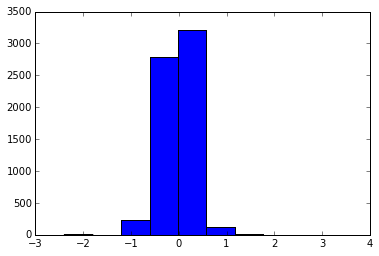

In [166]:
plt.hist(avg_profit_rates.values)

In [162]:
profit_rates.values.shape

(99706,)

In [97]:
profits1 = pre_dat_in_submit_by_account_event['correct_profit_loss'].sum()

In [19]:
event_counts = profits.groupby(level=0).size()

In [20]:
winning = profits1 > 0

In [22]:
winning = winning.groupby(level=0).all()

In [24]:
winning.head()

ACCOUNT_ID
1000002    False
1000004    False
1000005    False
1000010    False
1000014     True
dtype: bool

In [110]:
wins = winning.loc[((winning == True) & (event_counts > 2)).values].index

In [111]:
pre_dat_wins = pre_dat.loc[(pre_dat.ACCOUNT_ID.isin(wins)).values]

In [112]:
pre_dat_wins_by_account_event = pre_dat_wins.groupby(['ACCOUNT_ID', 'EVENT_ID'])

In [119]:
profit_rates = pre_dat_wins_by_account_event['correct_profit_loss'].sum() / pre_dat_wins_by_account_event['BET_SIZE'].sum()

In [120]:
profit_rates.groupby(level=0).std().describe()

count    177.000000
mean       0.243525
std        0.318516
min        0.000000
25%        0.068069
50%        0.135081
75%        0.309435
max        2.230303
dtype: float64

In [98]:
losing = profits1 < 0

In [99]:
losing = losing.groupby(level=0).all()

In [106]:
losing.loc[((losing == True) & (event_counts > 2)).values].shape

(133,)

In [96]:
losing.shape

(44, 23003)

In [27]:
event_counts.shape

(6373,)

In [370]:
test = create_bet_timeline(pre_dat.loc[((pre_dat.ACCOUNT_ID == 1000002) & (pre_dat.MATCH == 'Australia v New Zealand')).values])

In [371]:
test = test.loc[:, ['bet_date', 'backteam1']]

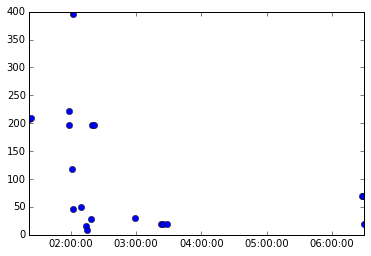

In [375]:
plt.plot(test.bet_date, test.backteam1, marker='o', linestyle='None')

In [299]:
#pre_dat_by_match = pre_dat.groupby('MATCH')
matchs = pre_dat.MATCH.unique()
for match in matchs:
    print(match)
    search_team = re.search(pattern, match)
    team1 = search_team.groupdict()['team1']
    team2 = search_team.groupdict()['team2']
    backteam1 = (pre_dat.MATCH == match) & (pre_dat.SELECTION_NAME == team1) & (pre_dat.BID_TYP == 'B')
    layteam1 = (pre_dat.MATCH == match) & (pre_dat.SELECTION_NAME == team1) & (pre_dat.BID_TYP == 'L')
    backteam2 = (pre_dat.MATCH == match) & (pre_dat.SELECTION_NAME == team2) & (pre_dat.BID_TYP == 'B')
    layteam2 = (pre_dat.MATCH == match) & (pre_dat.SELECTION_NAME == team2) & (pre_dat.BID_TYP == 'L')
    pre_dat.loc[:, 'backteam1'] = pre_dat.loc[backteam1.values, 'PRICE_TAKEN']
    pre_dat.loc[:, 'layteam1'] = pre_dat.loc[layteam1.values, 'PRICE_TAKEN']
    pre_dat.loc[:, 'backteam2'] = pre_dat.loc[backteam2.values, 'PRICE_TAKEN']
    pre_dat.loc[:, 'layteam2'] = pre_dat.loc[layteam2.values, 'PRICE_TAKEN']
    
match_timeline = pre_dat.loc[:, ['MATCH', 'TAKEN_DATE', 'backteam1', 'layteam1', 'backteam2', 'layteam2']]

Afghanistan v Scotland
Australia v Afghanistan
Australia v New Zealand
Australia v Pakistan
Australia v Scotland
Australia v Sri Lanka
Bangladesh v Afghanistan
Bangladesh v New Zealand
Bangladesh v Scotland
England v Afghanistan
England v Bangladesh
England v New Zealand
England v Scotland
England v Sri Lanka
India v Bangladesh
India v Ireland
India v Pakistan
India v United Arab Emirates
India v West Indies
India v Zimbabwe
Ireland v United Arab Emirates
Ireland v West Indies
New Zealand v Afghanistan
New Zealand v Scotland
New Zealand v Sri Lanka
New Zealand v West Indies
Pakistan v Ireland
Pakistan v United Arab Emirates
Pakistan v West Indies
Pakistan v Zimbabwe
South Africa v India
South Africa v Ireland
South Africa v Pakistan
South Africa v United Arab Emirates
South Africa v West Indies
South Africa v Zimbabwe
Sri Lanka v Afghanistan
Sri Lanka v Bangladesh
Sri Lanka v Scotland
Sri Lanka v South Africa
West Indies v United Arab Emirates
West Indies v Zimbabwe
Zimbabwe v Ireland


In [311]:
match_timeline.to_csv('match_timeline.csv', index=False)

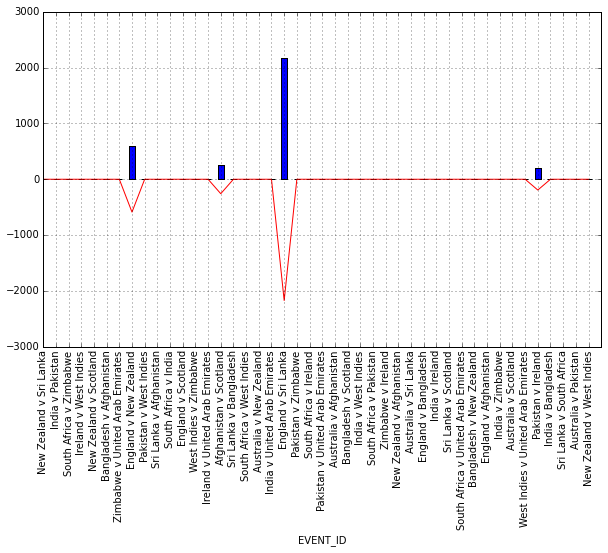

In [130]:
fig = plt.figure(figsize=(10, 6))
aid = 1000683
ax = fig.add_subplot(111)
ax = bet_size.loc[:, aid].plot(kind='bar', legend=False, rot=90, ax=ax)
ax = profits.loc[:, aid].plot(kind='line', legend=False, rot=90, ax=ax, color='r')
plt.xticks(range(len(event_ids.values) + 1), event_ids.values)
plt.grid()
plt.show()

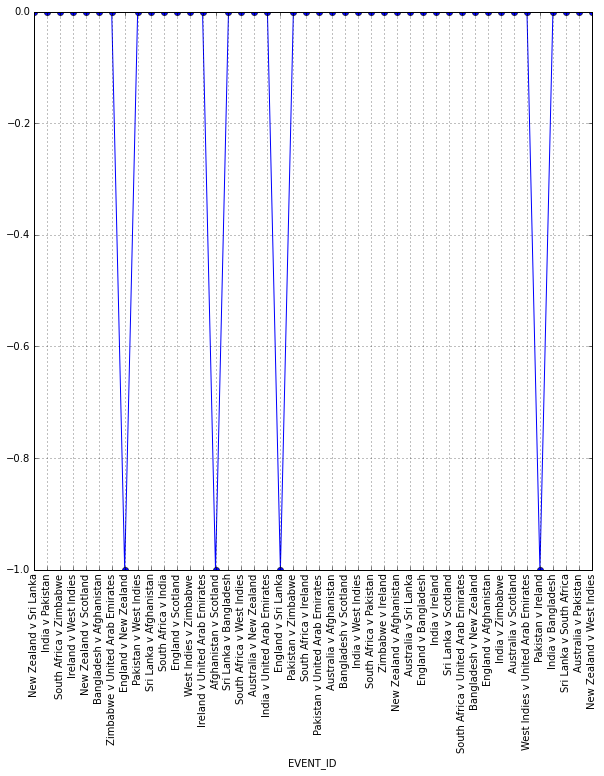

In [131]:
fig = plt.figure(figsize=(10, 10))
aid = 1000683
ax = fig.add_subplot(111)
ax = profit_rate.loc[:, aid].plot(kind='line', legend=False, rot=90, ax=ax, marker='o')
plt.xticks(range(len(event_ids.values)), event_ids.values)
plt.grid()
plt.show()

In [44]:
# have study on odds dynamics
def plot_odds_dynamics(game, bid_typ, from_time=None, accountid=None):
    pattern = '(?P<team1>.*) v (?P<team2>.*)'
    search_team = re.search(pattern, game)
    team1 = search_team.groupdict()['team1']
    team2 = search_team.groupdict()['team2']
    game_dat = pre_dat.loc[(pre_dat.MATCH == game).values, :]
    game_dat = game_dat.loc[:, ['BID_TYP', 'SELECTION_NAME', 'TAKEN_DATE', 'PRICE_TAKEN']]
    game_dat.loc[:, 'TAKEN_DATE'] = pd.to_datetime(game_dat.loc[:, 'TAKEN_DATE'],
                                                   dayfirst=True, infer_datetime_format=True)
    game_dat = game_dat.sort('TAKEN_DATE')
    game_dat = game_dat.set_index('TAKEN_DATE')
    if from_time is not None:
        back_game_dat = game_dat.loc[(game_dat.BID_TYP == bid_typ).values].loc[from_time:]
    else:
        back_game_dat = game_dat.loc[(game_dat.BID_TYP == bid_typ).values]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax = back_game_dat.loc[(back_game_dat.SELECTION_NAME == team1).values,
                           'PRICE_TAKEN'].plot(kind='line', logy=True, label=team1)
    back_game_dat.loc[(back_game_dat.SELECTION_NAME == team2).values,
                      'PRICE_TAKEN'].plot(kind='line', logy=True, ax=ax, color='r', label=team2)
    plt.legend(bbox_to_anchor=(.05, .99), loc=2)
    if accountid is not None:
        ax_twin = ax.twinx()
        bet_timeline = create_bet_timeline(pre_dat.loc[((pre_dat.ACCOUNT_ID == accountid) & (pre_dat.MATCH == game)).values, :])
        if bid_typ == 'B':
            bet_timeline = bet_timeline.loc[:, ['bet_date', 'backteam1', 'backteam2']]
        elif bid_typ == 'L':
            bet_timeline = bet_timeline.loc[:, ['bet_date', 'layteam1', 'layteam2']]
        if from_time is not None:
            bet_timeline = bet_timeline.loc[(bet_timeline.bet_date > from_time).values]
            bet_timeline = bet_timeline.set_index('bet_date')
            try:
                bet_timeline.iloc[:, 0].plot(kind='line', ax=ax_twin, logy=True, markersize=20, linestyle='None', legend=False, marker='o')
            except ValueError:
                pass
            try:
                bet_timeline.iloc[:, 1].plot(kind='line', ax=ax_twin, logy=True, markersize=20, markerfacecolor='r', linestyle='None', legend=False, marker='o')  
            except ValueError:
                pass
    plt.grid()

IndexError: index 0 is out of bounds for axis 0 with size 0

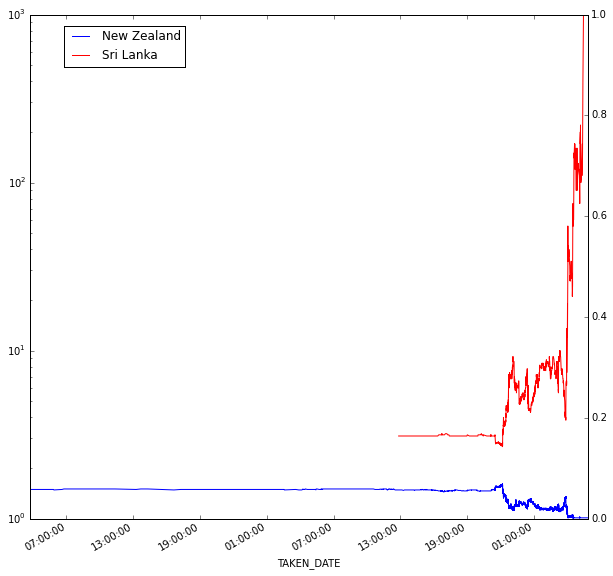

In [114]:
plot_odds_dynamics('New Zealand v Sri Lanka', 'B', from_time='2015-02-12', accountid=1000002)

In [49]:
create_bet_timeline(pre_dat.loc[((pre_dat.ACCOUNT_ID == 1001323) & (pre_dat.MATCH == 'South Africa v Zimbabwe')).values, :])

,bet_date,backteam1,layteam1,backteam2,layteam2
BET_ID,,,,,
4753336681,2015-02-15 01:31:31,NaN,NaN,NaN,19.84500
4753336977,2015-02-15 01:31:42,NaN,178.783605,NaN,NaN
4753376977,2015-02-15 01:45:22,NaN,NaN,NaN,9.92250
4753378048,2015-02-15 01:45:33,NaN,51.696225,NaN,NaN
4755755843,2015-02-15 07:52:12,NaN,NaN,4.00869,NaN
4755757059,2015-02-15 07:52:29,NaN,NaN,NaN,4.24683
4755784478,2015-02-15 08:00:21,NaN,NaN,NaN,3.96900
4755784989,2015-02-15 08:00:31,NaN,55.724760,NaN,NaN
4755785623,2015-02-15 08:00:45,NaN,0.515970,NaN,NaN


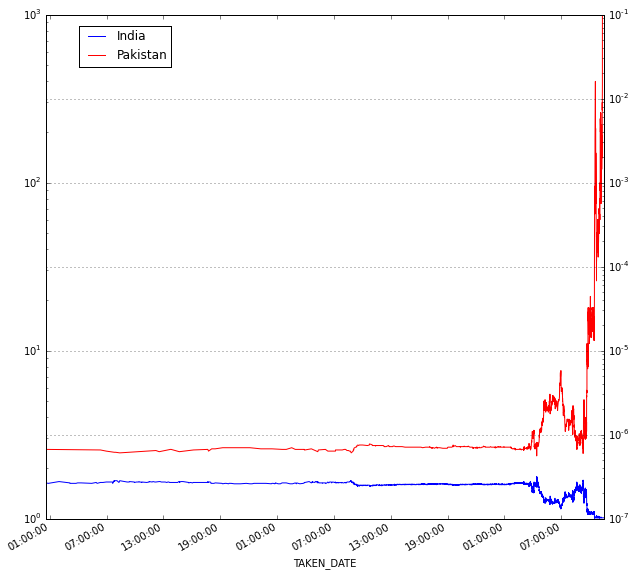

In [86]:
plot_odds_dynamics('India v Pakistan', 'L', from_time='2015-02-13', accountid=1002770)

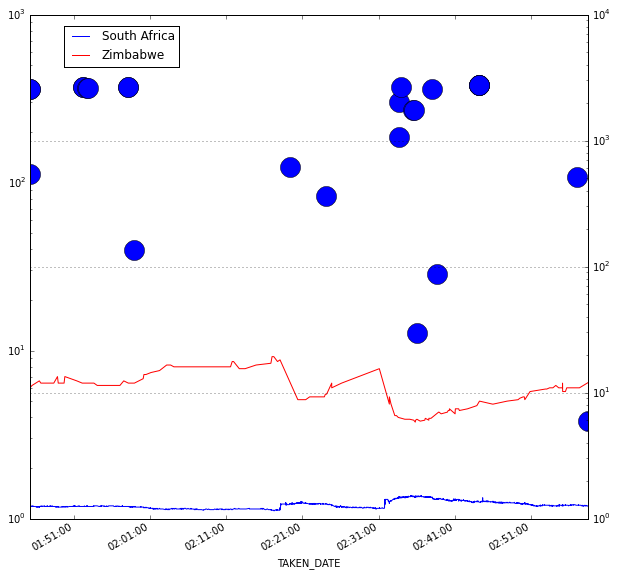

In [59]:
plot_odds_dynamics('South Africa v Zimbabwe', 'B', from_time='2015-02-15', accountid=1002304)

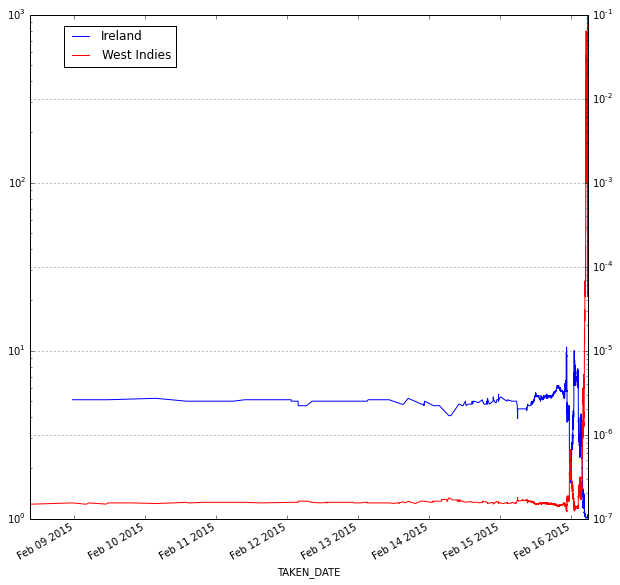

In [88]:
plot_odds_dynamics('Ireland v West Indies', 'L', '2015-02-08', accountid=1002770)

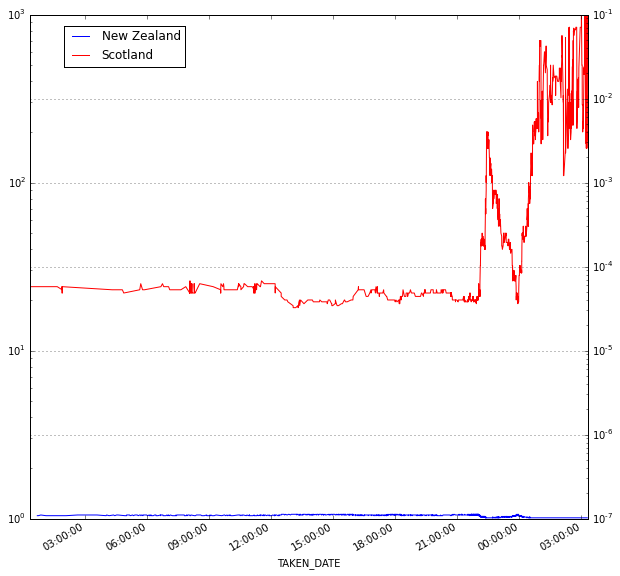

In [107]:
plot_odds_dynamics('New Zealand v Scotland', 'B', from_time='2015-02-16', accountid=1000004)

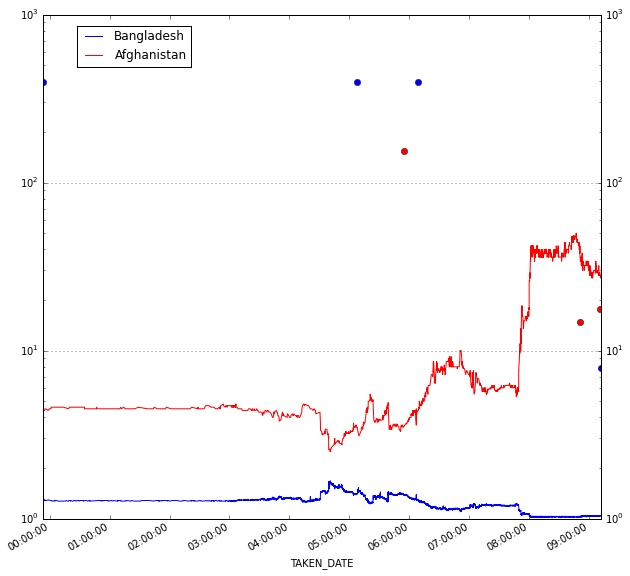

In [51]:
plot_odds_dynamics('Bangladesh v Afghanistan', 'B', '2015-02-16', accountid=1000002)

IndexError: index 0 is out of bounds for axis 0 with size 0

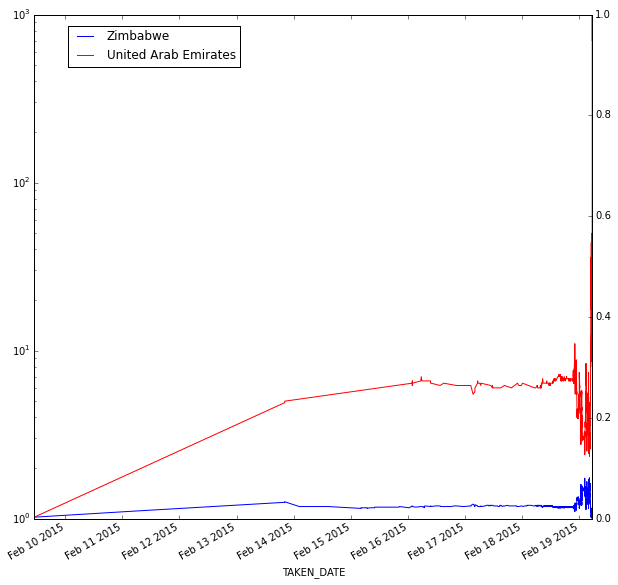

In [66]:
plot_odds_dynamics('Zimbabwe v United Arab Emirates', 'B', '2015-02-01', accountid=1002355)

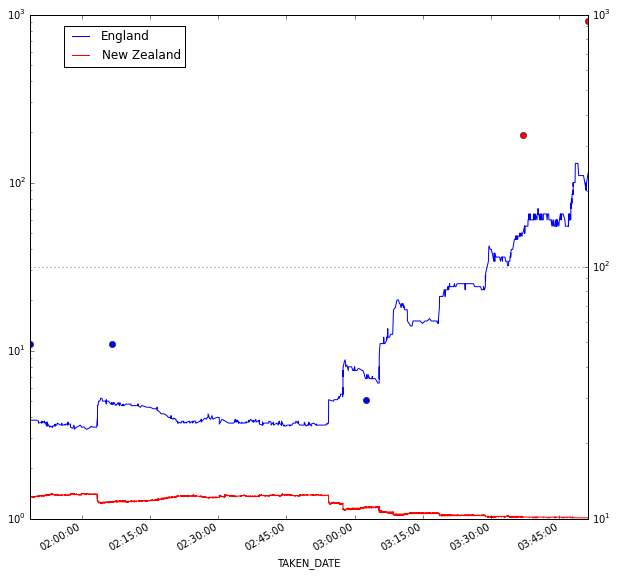

In [50]:
plot_odds_dynamics('England v New Zealand', 'B', '2015-02-20', 1000002)

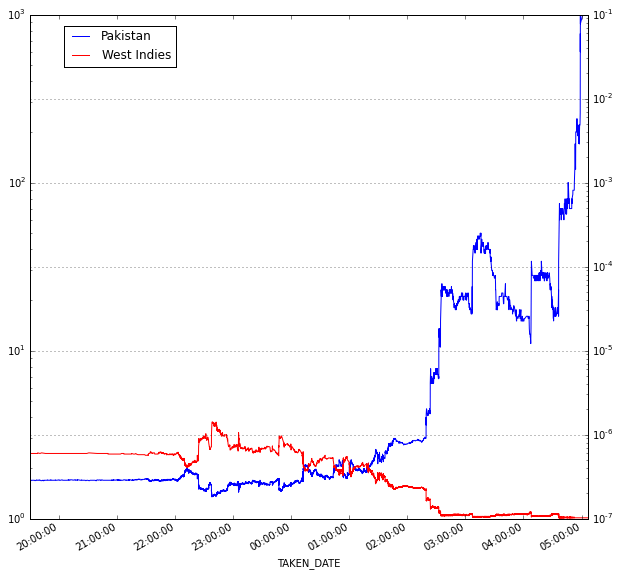

In [68]:
plot_odds_dynamics('Pakistan v West Indies', 'B', '2015-02-20 19:30', 1002355)

IndexError: index 0 is out of bounds for axis 0 with size 0

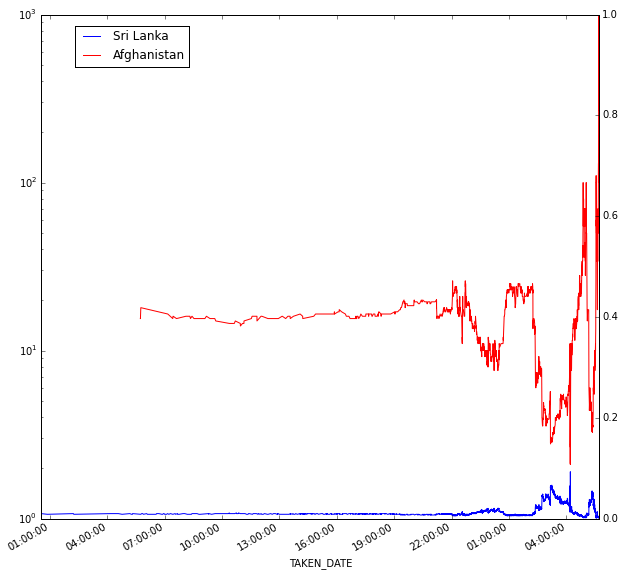

In [58]:
plot_odds_dynamics('Sri Lanka v Afghanistan', 'B', '2015-02-21', 1000002)

IndexError: index 0 is out of bounds for axis 0 with size 0

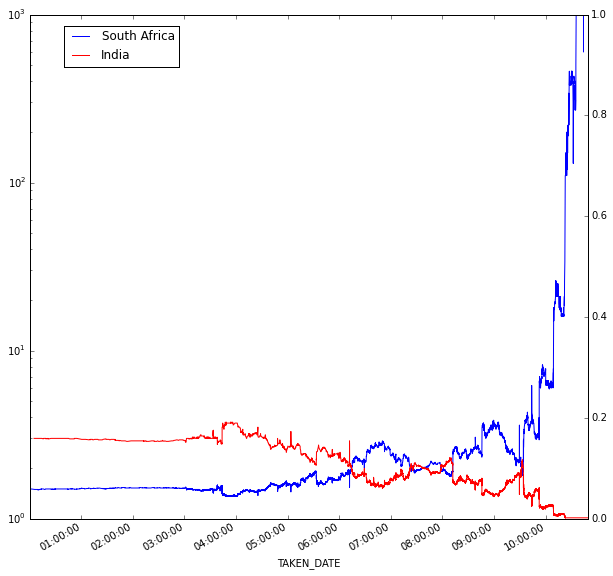

In [59]:
plot_odds_dynamics('South Africa v India', 'B', '2015-02-22 00:00', 1000002)

IndexError: index 0 is out of bounds for axis 0 with size 0

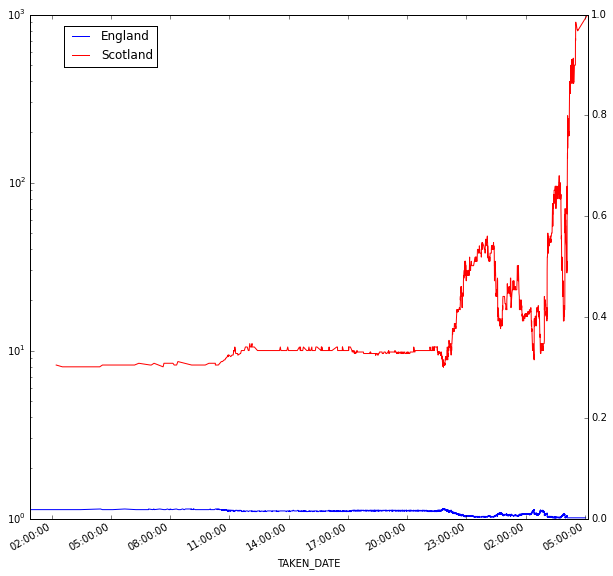

In [60]:
plot_odds_dynamics('England v Scotland', 'B', '2015-02-22 00:00', 1000002)

IndexError: index 0 is out of bounds for axis 0 with size 0

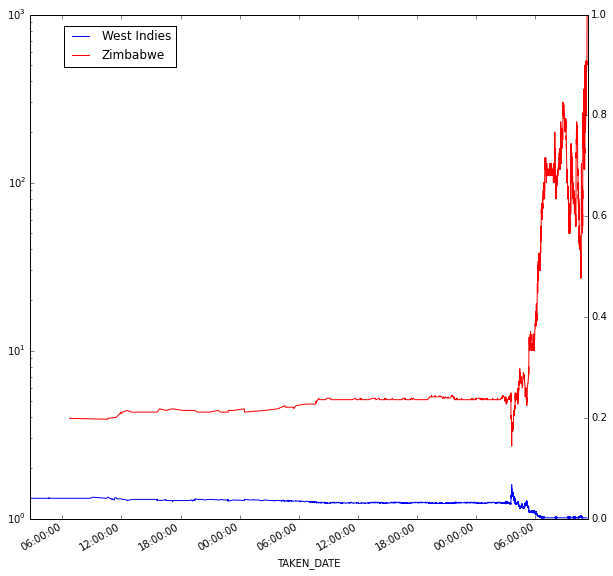

In [61]:
plot_odds_dynamics('West Indies v Zimbabwe', 'B', '2015-02-22 00:00', 1000002)

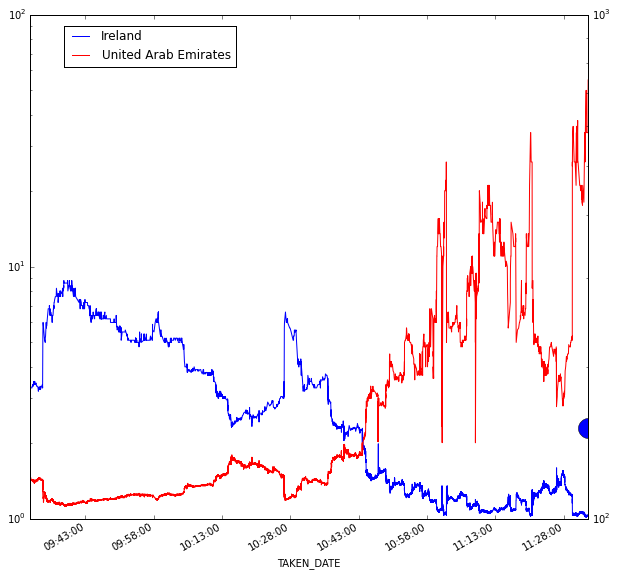

In [71]:
plot_odds_dynamics('Ireland v United Arab Emirates', 'L', '2015-02-20 00:00', 1002355)

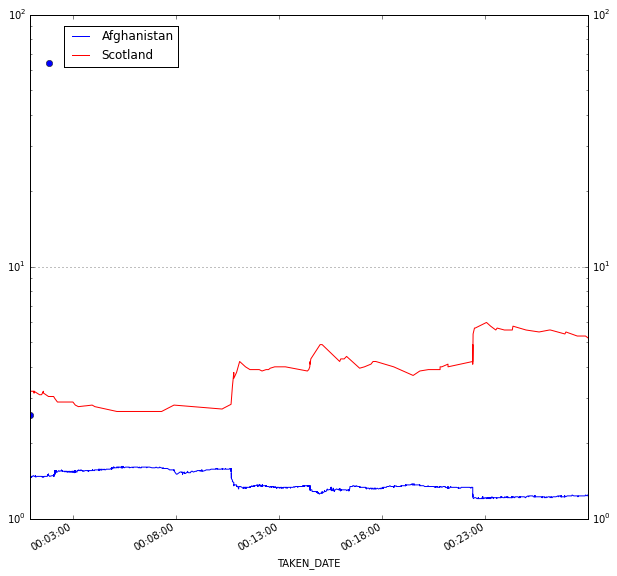

In [75]:
plot_odds_dynamics('Afghanistan v Scotland', 'L', from_time='2015-02-10', accountid=1000009)

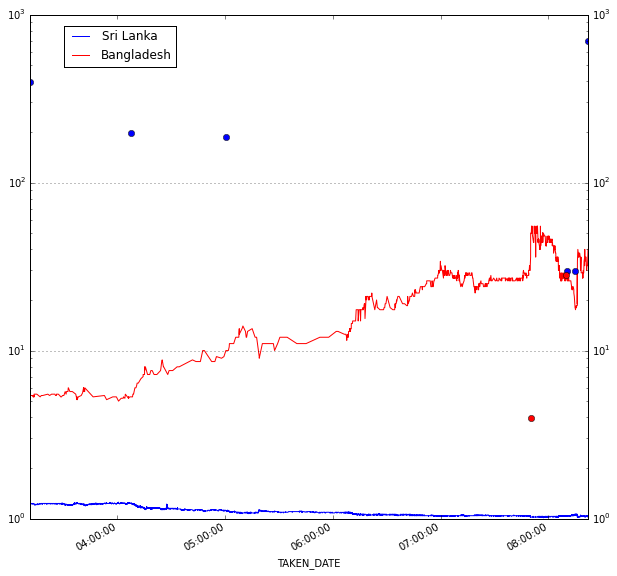

In [67]:
plot_odds_dynamics('Sri Lanka v Bangladesh', 'B', from_time='2015-02-26', accountid=1000002)

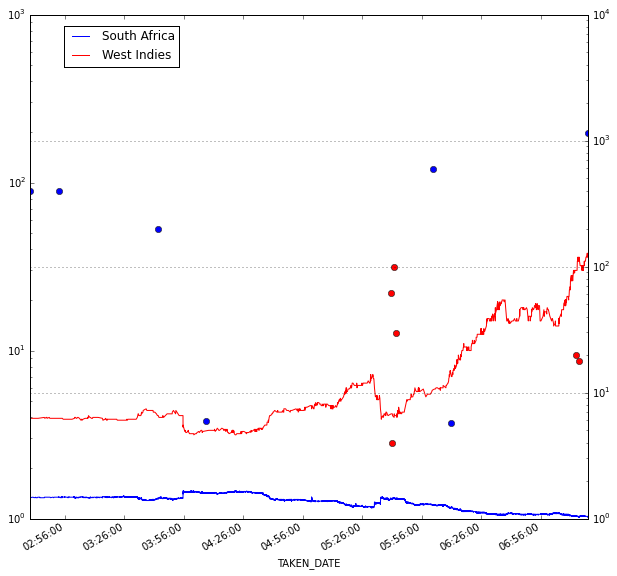

In [68]:
plot_odds_dynamics('South Africa v West Indies', 'B', '2015-02-27 00:00', 1000002)

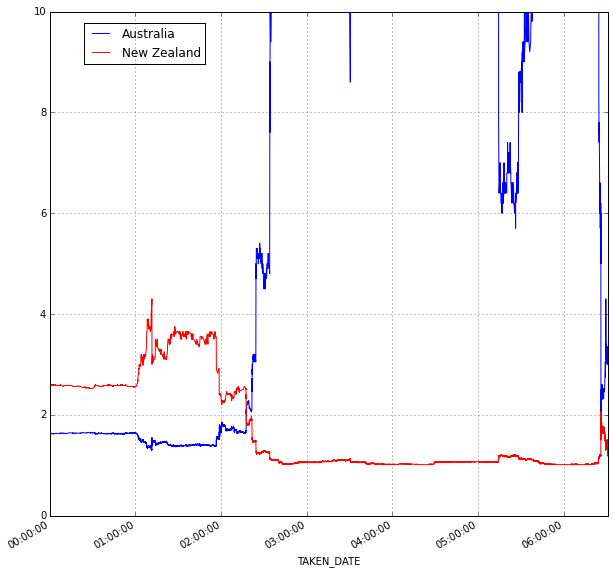

In [511]:
plot_odds_dynamics('Australia v New Zealand', 'L', '2015-02-28 00:00')

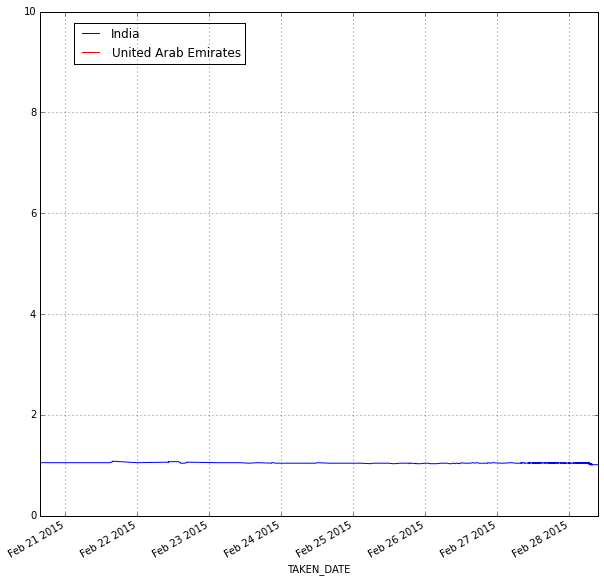

In [514]:
plot_odds_dynamics('India v United Arab Emirates', 'L')

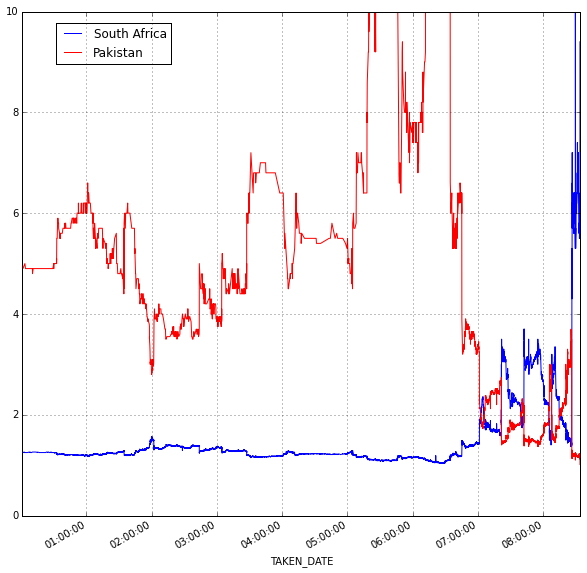

In [516]:
plot_odds_dynamics('South Africa v Pakistan', 'B', '2015-03-07 00:00')

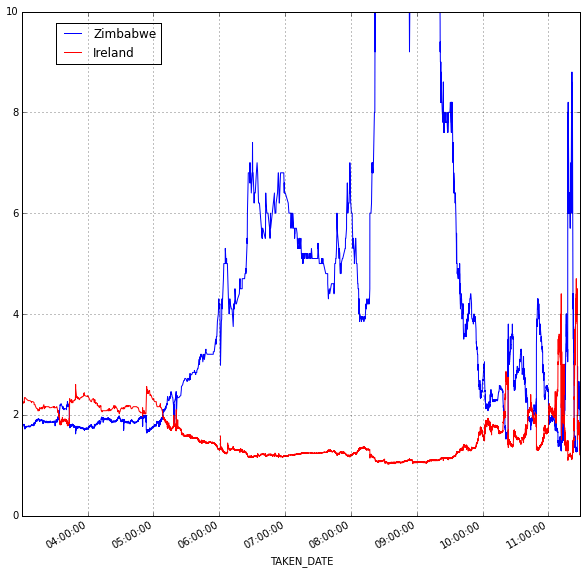

In [518]:
plot_odds_dynamics('Zimbabwe v Ireland', 'L', '2015-03-07 00:00')

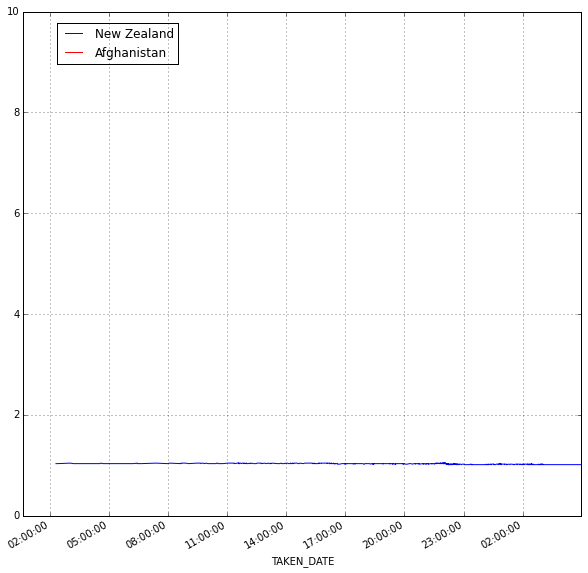

In [520]:
plot_odds_dynamics('New Zealand v Afghanistan', 'L', '2015-03-07 00:00')

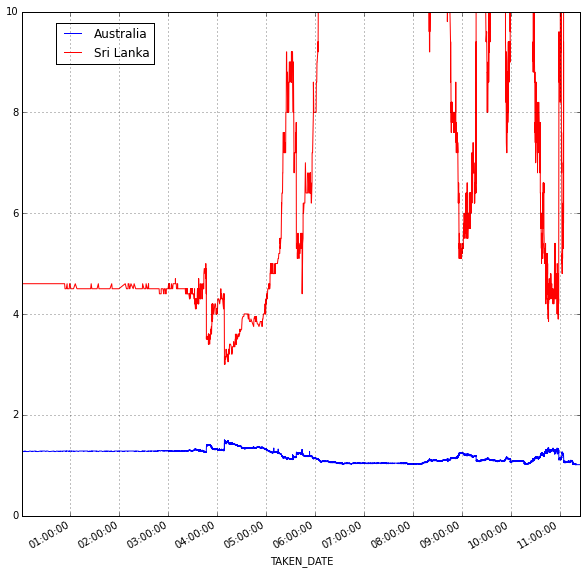

In [522]:
plot_odds_dynamics('Australia v Sri Lanka', 'L', '2015-03-08 00:00')

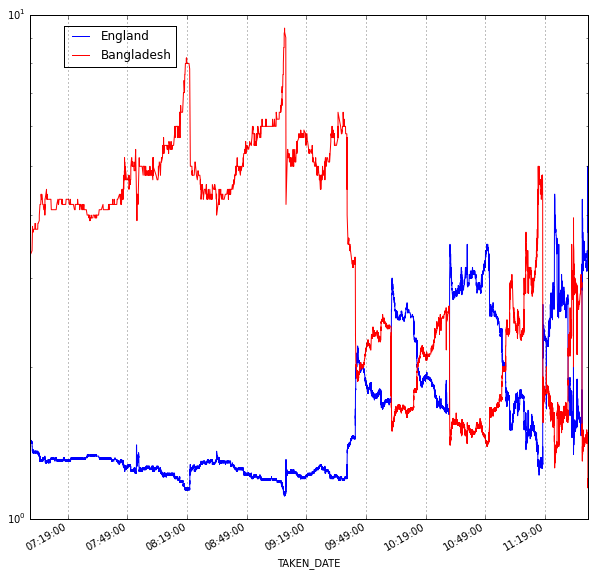

In [127]:
plot_odds_dynamics('England v Bangladesh', 'L', '2015-03-09 07:00')

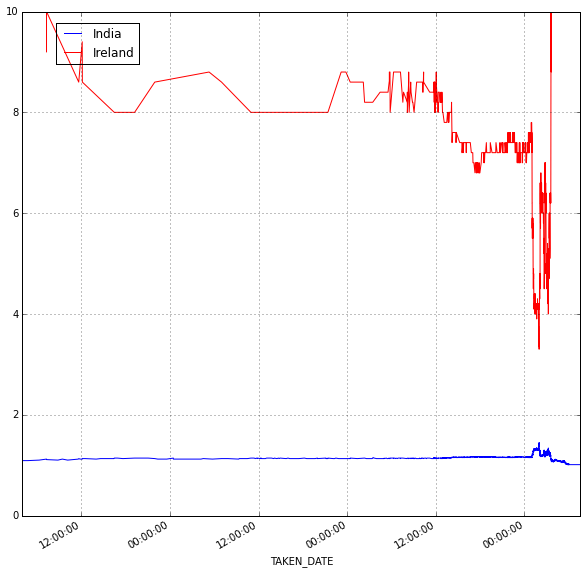

In [526]:
plot_odds_dynamics('India v Ireland', 'L', '2015-03-07 00:00')

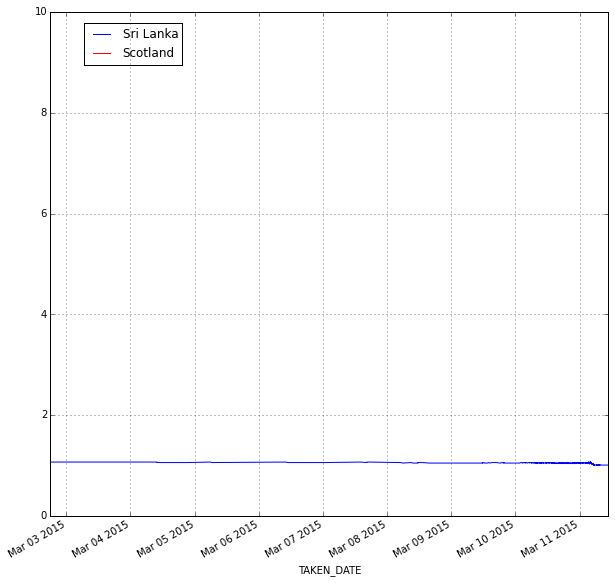

In [529]:
plot_odds_dynamics('Sri Lanka v Scotland', 'L')

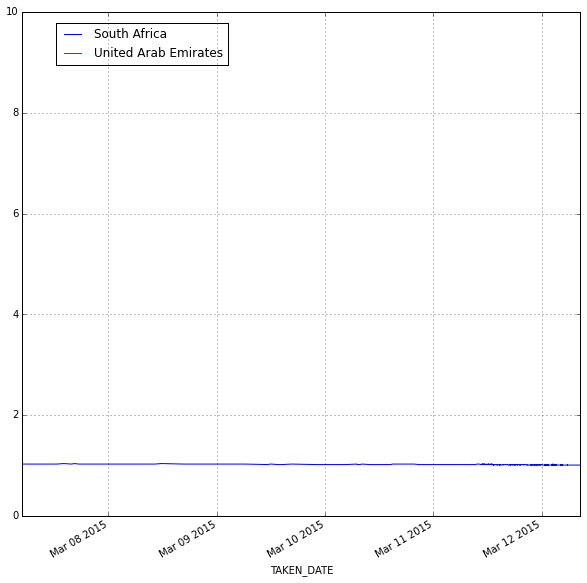

In [531]:
plot_odds_dynamics('South Africa v United Arab Emirates', 'L', '2015-03-07 00:00')

IndexError: index 0 is out of bounds for axis 0 with size 0

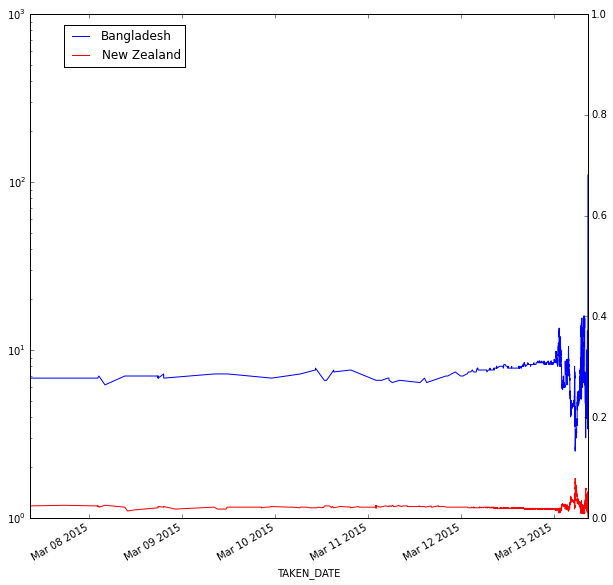

In [72]:
plot_odds_dynamics('Bangladesh v New Zealand', 'L', '2015-03-07 00:00', 1002355)

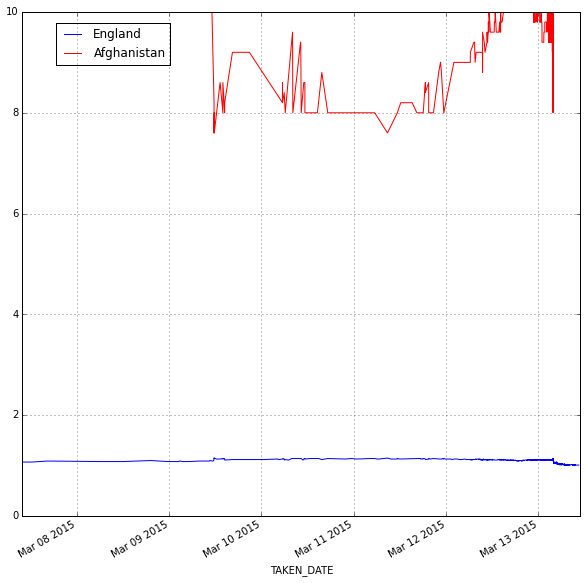

In [535]:
plot_odds_dynamics('England v Afghanistan', 'L', '2015-03-07 00:00')

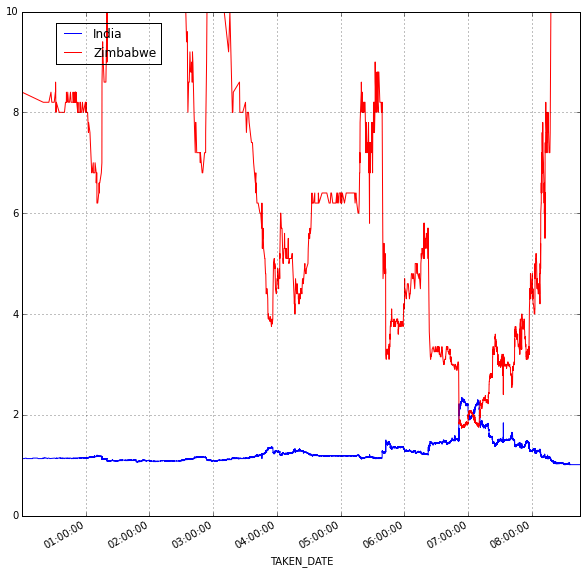

In [537]:
plot_odds_dynamics('India v Zimbabwe', 'L', '2015-03-14 00:00')

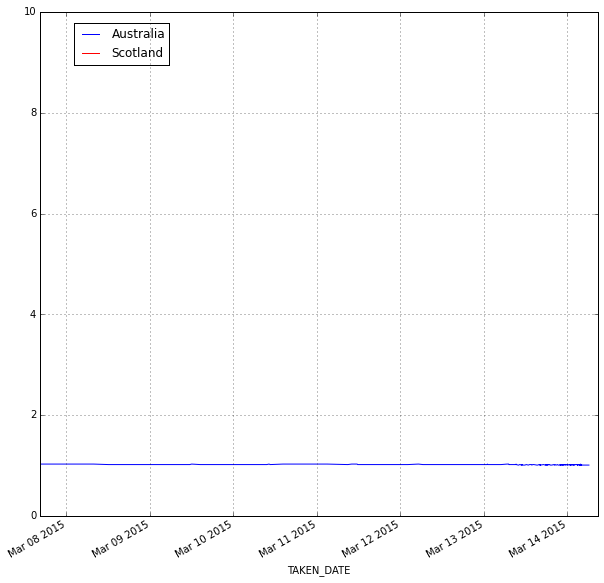

In [538]:
plot_odds_dynamics('Australia v Scotland', 'B', '2015-03-07 00:00')

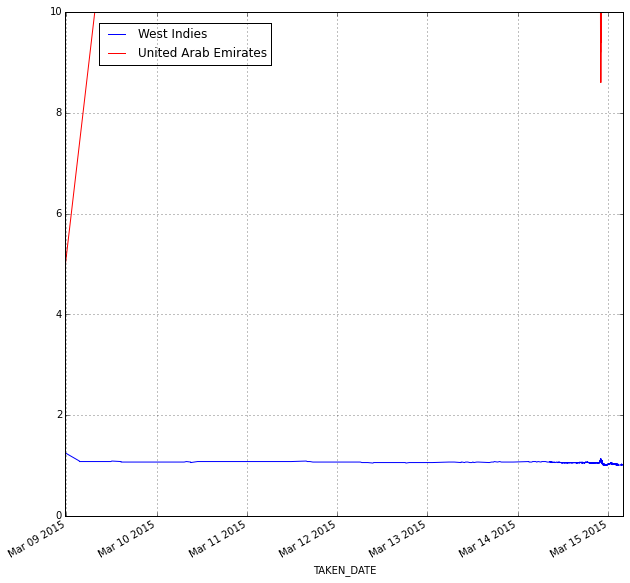

In [540]:
plot_odds_dynamics('West Indies v United Arab Emirates', 'L', '2015-03-07 00:00')

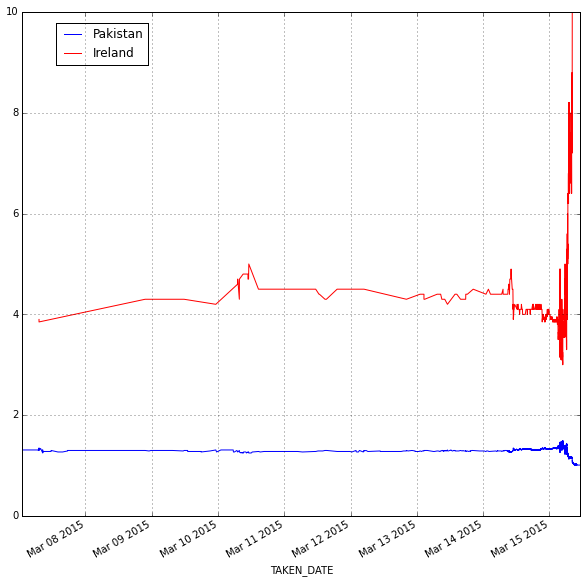

In [542]:
plot_odds_dynamics('Pakistan v Ireland', 'L', '2015-03-07 00:00')

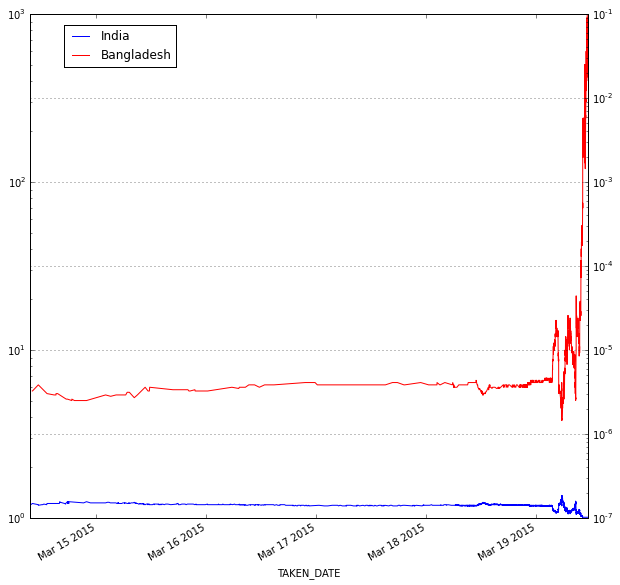

In [74]:
plot_odds_dynamics('India v Bangladesh', 'L', '2015-03-07 00:00', 1002355)

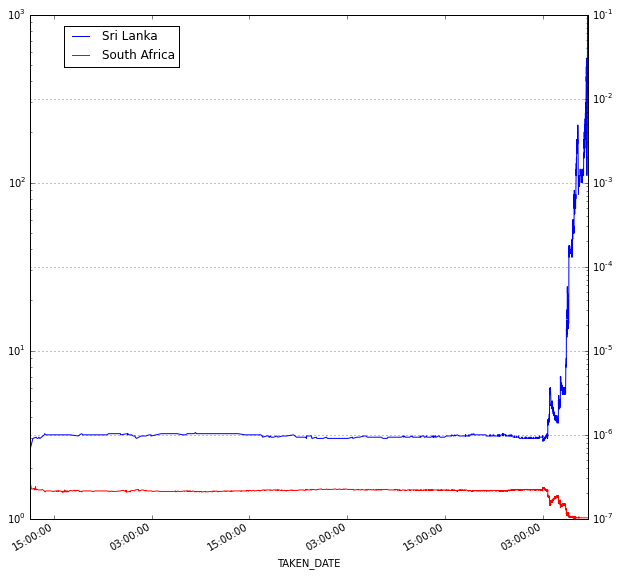

In [76]:
plot_odds_dynamics('Sri Lanka v South Africa', 'L', '2015-03-07 00:00', 1002355)

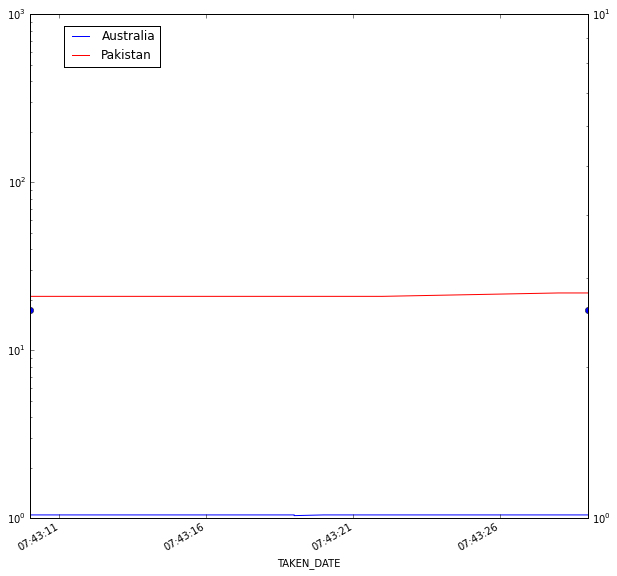

In [84]:
plot_odds_dynamics('Australia v Pakistan', 'L', from_time='2015-02-15', accountid=1000009)

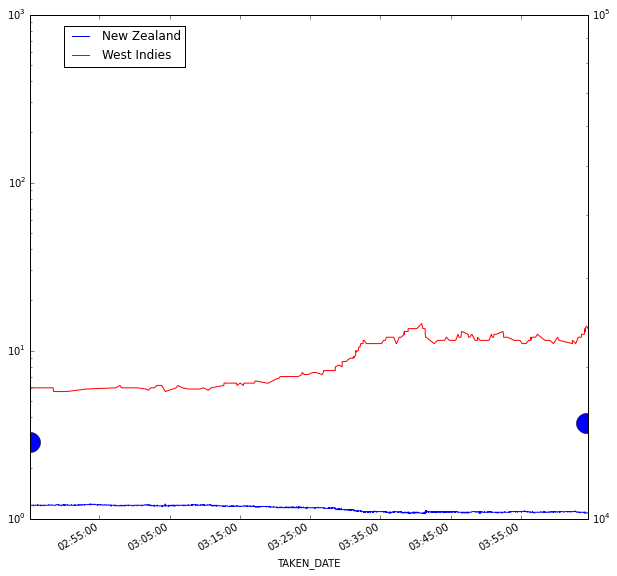

In [81]:
plot_odds_dynamics('New Zealand v West Indies', 'B', '2015-03-07 00:00', 1002420)

In [16]:
def pre_avg_bet_game(df):
    total_size = df.BET_SIZE.sum()
    return total_size / len(set(df.EVENT_ID))

In [431]:
# to see winners and losers percentage for each game
pre_dat_by_game_account = pre_dat.groupby(['MATCH', 'ACCOUNT_ID'])
net_profit = pre_dat_by_game_account['correct_profit_loss'].sum()
is_profit = net_profit > 0
is_profit_by_game = is_profit.groupby(level=0)
perc = is_profit_by_game.sum() / is_profit_by_game.size() * 100
perc = perc.reindex(index=event_ids.values)

In [434]:
is_profit_by_account = is_profit.groupby(level=1)

In [436]:
always_win = is_profit_by_account.apply(all)

In [437]:
game_num = is_profit_by_account.size()

In [442]:
always_win.loc[((game_num > 40) & always_win).values]

ACCOUNT_ID
1001448    True
1016797    True
dtype: bool

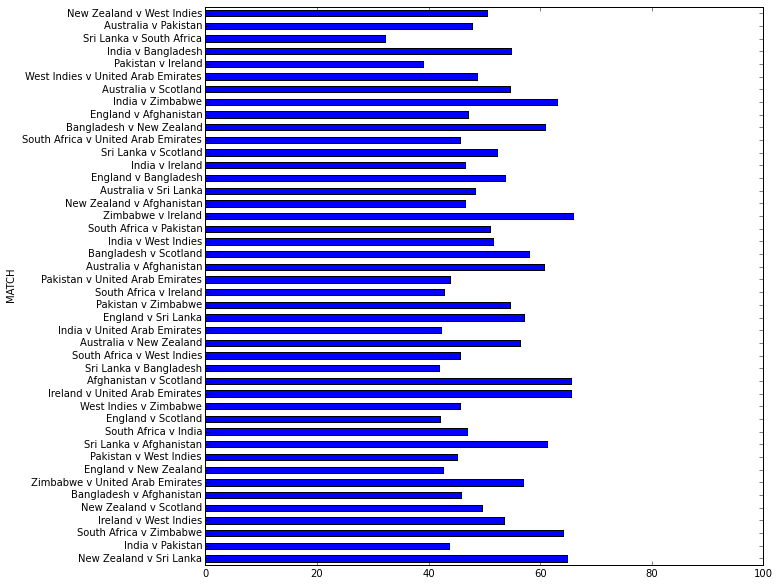

In [80]:
# eventually I wanna see a dual axis charts, bar charts is for number of punters,
# line charts is for percentage of winners
plt.figure(figsize=(10, 10))
perc.plot(kind='barh', xlim=(0, 100))

In [17]:
pre_dat_by_accountid = pre_dat.groupby('ACCOUNT_ID')

In [18]:
pre_game_bet = pre_dat_by_accountid.apply(pre_avg_bet_game)

In [19]:
pre_game_bet.head()

ACCOUNT_ID
682     8770.514000
1011      98.990000
1534    2049.706738
1887     595.919800
2155      49.495000
dtype: float64

In [22]:
pre_game_bet = pre_game_bet.loc[submit.Account_ID.tolist()]

In [23]:
pre_game_bet.shape

(7374,)

In [31]:
(last_bet_game / pre_game_bet).idxmax()

1007874

In [32]:
last_bet_game.loc[1007874]

801106.5054500004

In [33]:
pre_game_bet.loc[1007874]

352.70224999999999

In [34]:
dat.loc[(dat.Account_ID == 1007874).values]

,Account_ID,EVENT_ID,TRANSACTION_COUNT,STATUS_ID,INPLAY_BET,AVG_BET_SIZE,MAX_BET_SIZE,MIN_BET_SIZE,STDEV_BET_SIZE
20535,1007874,101187238,2,C,N,96865.103655,126460.006323,67270.200987,41853.512730
20536,1007874,101187238,1,C,N,126460.006323,126460.006323,126460.006323,0.000000
20537,1007874,101187238,23,S,N,4893.451899,23835.705609,0.948450,7119.065585
20538,1007874,101187238,129,S,N,2244.910274,50584.006323,3.793800,6691.629148
20539,1007874,101187238,79,S,Y,4923.936523,62581.879854,3.793800,9749.773472
20540,1007874,101187238,79,S,Y,2884.568768,50584.006323,2.181435,7433.829992
20541,1007874,101187943,6,C,N,22281.822065,26406.800000,10748.152322,5935.130896
20542,1007874,101187943,3,C,N,26825.951364,30179.200000,25149.327046,2903.998504
20543,1007874,101187943,125,S,Y,1911.171628,25791.389526,1.131720,4189.505123
20544,1007874,101187943,25,S,Y,6473.437646,26723.228912,25.218494,9727.497184


In [27]:
pre_game_bet.head()

ACCOUNT_ID
1004240     15609.040322
1009742    338145.578932
1003908      1299.918483
1020888        96.370000
1010074      2784.282930
dtype: float64

In [366]:
pre_dat_bet_freq = pre_dat_by_accountid['EVENT_ID'].apply(lambda x: len(set(x)))

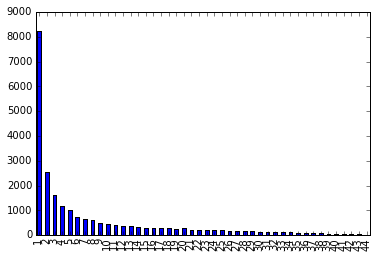

In [383]:
pre_dat_bet_freq.value_counts().sort_index().plot(kind='bar', legend=False)

In [378]:
subset = pre_dat.loc[pre_dat.ACCOUNT_ID.isin(submit.Account_ID)]

In [379]:
subset_by_accountid = subset.groupby('ACCOUNT_ID')

In [380]:
subset_bet_freq = subset_by_accountid['EVENT_ID'].apply(lambda x: len(set(x)))

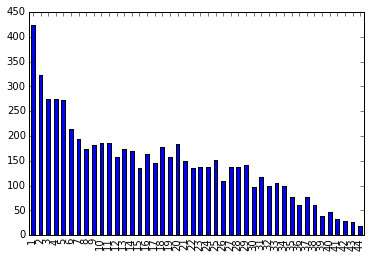

In [384]:
subset_bet_freq.value_counts().sort_index().plot(kind='bar', legend=False)

In [385]:
final_bet_freq = final_by_account['EVENT_ID'].apply(lambda x: len(set(x)))

In [387]:
final_bet_freq.name = 'final_bet_freq'

In [394]:
subset_bet_freq = pd.concat([subset_bet_freq, final_bet_freq], axis=1)

In [395]:
subset_bet_freq.head()

,EVENT_ID,final_bet_freq
1000002,26,3
1000004,12,1
1000005,8,2
1000010,24,2
1000014,1,3


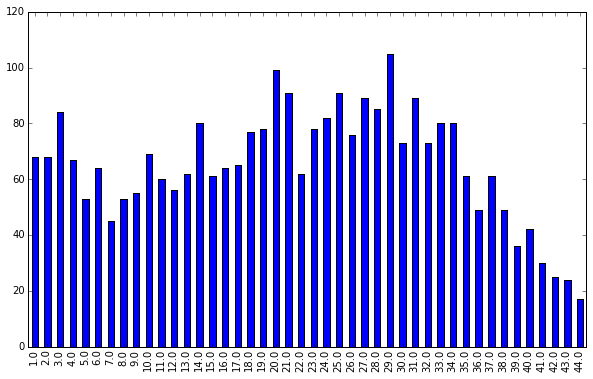

In [400]:
plt.figure(figsize=(10, 6))
subset_bet_freq.loc[(subset_bet_freq.final_bet_freq == 3).values, 'EVENT_ID'].value_counts().sort_index().plot(kind='bar', legend=False)

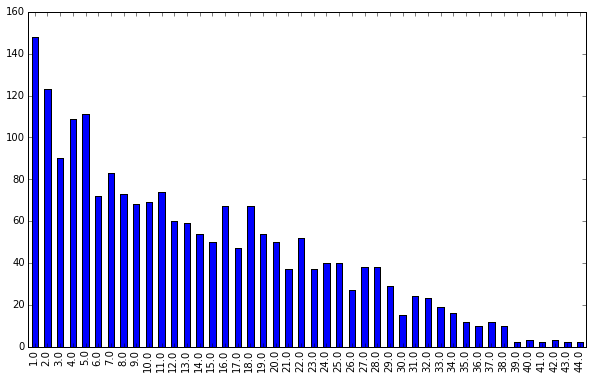

In [401]:
plt.figure(figsize=(10, 6))
subset_bet_freq.loc[(subset_bet_freq.final_bet_freq == 2).values, 'EVENT_ID'].value_counts().sort_index().plot(kind='bar', legend=False)

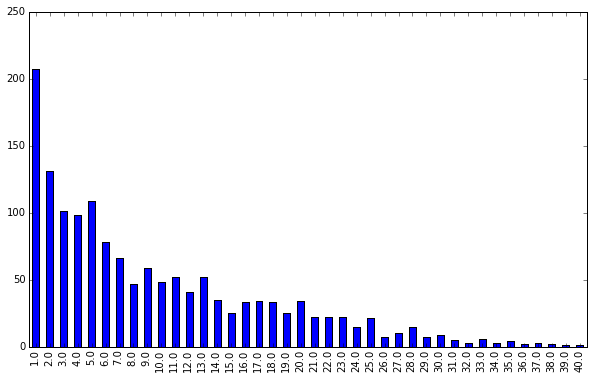

In [402]:
plt.figure(figsize=(10, 6))
subset_bet_freq.loc[(subset_bet_freq.final_bet_freq == 1).values, 'EVENT_ID'].value_counts().sort_index().plot(kind='bar', legend=False)

In [406]:
new_comers = submit.loc[~submit.Account_ID.isin(pre_dat.ACCOUNT_ID), 'Account_ID'].tolist()
new_comer_dat = dat.loc[dat.Account_ID.isin(new_comers)]

In [409]:
new_comer_dat.groupby('Account_ID')['EVENT_ID'].apply(lambda x: len(set(x))).value_counts()

1    594
2    281
3    114
dtype: int64

In [411]:
subset_by_accountid_eventid = subset.groupby(['ACCOUNT_ID', 'EVENT_ID'])

In [413]:
subset_perf = subset_by_accountid_eventid['correct_profit_loss'].sum()

In [417]:
is_subset_win = subset_perf.groupby(level=0).apply(lambda x: x > 0)

In [418]:
is_subset_win.name = 'is_win'

In [419]:
is_subset_win = is_subset_win.reset_index()

In [422]:
subset_always_win = is_subset_win.groupby('ACCOUNT_ID')['is_win'].apply(all)

In [423]:
subset_always_win.value_counts()

False    5975
True      410
dtype: int64

In [424]:
# do they bet often? 
subset.loc[subset.ACCOUNT_ID.isin(subset_always_win.loc[subset_always_win.values].index.tolist())].groupby('ACCOUNT_ID')['EVENT_ID'].apply(lambda x: len(set(x))).value_counts()

1     176
2      89
3      54
4      28
5      24
6       9
7       5
9       5
8       4
11      4
10      3
12      2
17      2
26      1
15      1
18      1
19      1
40      1
dtype: int64

In [428]:
subset_always_win = subset_always_win.loc[submit.Account_ID]

In [430]:
subset_always_win = subset_always_win.fillna(False)

In [432]:
subset_always_win.name = 'Prediction'
subset_always_win.index.name = 'Account_ID'
subset_always_win = subset_always_win.reset_index()

In [435]:
subset_always_win.loc[:, 'Prediction'] = subset_always_win.Prediction.apply(int)

In [437]:
subset_always_win.to_csv('always_wins.csv', index=False)

In [439]:
# now I wanna get the faith each one got on the four teams
def loyalty_checker(df, country='Australia'):
    is_playing = df.MATCH.str.contains(country)
    df = df.loc[is_playing.values]
    is_for = ((df.SELECTION_NAME == country) & (df.BID_TYP == 'B')) | ((df.SELECTION_NAME != country) & (df.BID_TYP == 'L'))
    return df.loc[is_for].groupby('MATCH')['BET_SIZE'].sum().mean()                                                                                               

In [483]:
res = subset_by_accountid[['SELECTION_NAME', 'BID_TYP', 'BET_SIZE', 'MATCH']].apply(loyalty_checker, country='India')

In [470]:
faith_table = pd.DataFrame({})

In [484]:
res.name = 'India'
res = res.reset_index()

In [469]:
res.head()

,ACCOUNT_ID,South Africa
0,1000002,1881.143613
1,1000004,367.469625
2,1000005,5058.250000
3,1000010,494.751600
4,1000014,100.000000


In [485]:
faith_table = pd.concat([faith_table, res.iloc[:, 1]], axis=1)

In [487]:
faith_table = faith_table.fillna(0)
faith_table.head()

,ACCOUNT_ID,South Africa,Australia,New Zealand,India
0,1000002,1881.143613,2900.5274,1963.477738,2608.7174
1,1000004,367.469625,37.5098,0.000000,0.0000
2,1000005,5058.250000,1103.1780,0.000000,13643.4375
3,1000010,494.751600,0.0000,969.700000,795.2424
4,1000014,100.000000,0.0000,0.000000,0.0000


In [69]:
sim_dat = dat.loc[(dat.Account_ID.isin(faith_table.ACCOUNT_ID) & dat.STATUS_ID.isin(['S'])).values]

NameError: name 'faith_table' is not defined

In [68]:
sim_dat.loc[:, 'total'] = sim_dat.loc[:, 'TRANSACTION_COUNT'] * sim_dat.loc[:, 'AVG_BET_SIZE']

NameError: name 'sim_dat' is not defined

In [492]:
sim_dat1 = sim_dat[['Account_ID', 'EVENT_ID', 'total']]

In [495]:
sim_dat1 = pd.merge(sim_dat1, faith_table, left_on='Account_ID', right_on='ACCOUNT_ID')

In [496]:
sim_dat1.head()

,Account_ID,EVENT_ID,total,ACCOUNT_ID,South Africa,Australia,New Zealand,India
0,1000002,101187238,557.688600,1000002,1881.143613,2900.5274,1963.477738,2608.7174
1,1000002,101187238,6117.787035,1000002,1881.143613,2900.5274,1963.477738,2608.7174
2,1000002,101187943,12563.978200,1000002,1881.143613,2900.5274,1963.477738,2608.7174
3,1000002,101191295,237.300152,1000002,1881.143613,2900.5274,1963.477738,2608.7174
4,1000002,101191295,749.518864,1000002,1881.143613,2900.5274,1963.477738,2608.7174


In [498]:
won_first = (sim_dat1.EVENT_ID == 101187238) & (sim_dat1.loc[:, 'New Zealand'] > sim_dat1.loc[:, 'South Africa'])  
lost_first = (sim_dat1.EVENT_ID == 101187238) & (sim_dat1.loc[:, 'New Zealand'] < sim_dat1.loc[:, 'South Africa'])
no_first = (sim_dat1.EVENT_ID == 101187238) & (sim_dat1.loc[:, 'New Zealand'] == sim_dat1.loc[:, 'South Africa'])
won_second = (sim_dat1.EVENT_ID == 101187943) & (sim_dat1.loc[:, 'Australia'] > sim_dat1.loc[:, 'India'])  
lost_second = (sim_dat1.EVENT_ID == 101187943) & (sim_dat1.loc[:, 'Australia'] < sim_dat1.loc[:, 'India'])
no_second = (sim_dat1.EVENT_ID == 101187943) & (sim_dat1.loc[:, 'Australia'] == sim_dat1.loc[:, 'India'])
won_third = (sim_dat1.EVENT_ID == 101191295) & (sim_dat1.loc[:, 'Australia'] > sim_dat1.loc[:, 'New Zealand'])  
lost_third = (sim_dat1.EVENT_ID == 101191295) & (sim_dat1.loc[:, 'Australia'] < sim_dat1.loc[:, 'New Zealand'])
no_third = (sim_dat1.EVENT_ID == 101191295) & (sim_dat1.loc[:, 'Australia'] == sim_dat1.loc[:, 'New Zealand'])

In [501]:
sim_dat1.loc[won_first.values, 'result'] = sim_dat1.loc[won_first.values, 'total']
sim_dat1.loc[lost_first.values, 'result'] = - sim_dat1.loc[lost_first.values, 'total']
sim_dat1.loc[no_first.values, 'result'] = 0
sim_dat1.loc[won_second.values, 'result'] = sim_dat1.loc[won_second.values, 'total']
sim_dat1.loc[lost_second.values, 'result'] = - sim_dat1.loc[lost_second.values, 'total']
sim_dat1.loc[no_second.values, 'result'] = 0
sim_dat1.loc[won_third.values, 'result'] = sim_dat1.loc[won_third.values, 'total']
sim_dat1.loc[lost_third.values, 'result'] = - sim_dat1.loc[lost_third.values, 'total']
sim_dat1.loc[no_second.values, 'result'] = 0

In [502]:
sim_dat1.head()

,Account_ID,EVENT_ID,total,ACCOUNT_ID,South Africa,Australia,New Zealand,India,result
0,1000002,101187238,557.688600,1000002,1881.143613,2900.5274,1963.477738,2608.7174,557.688600
1,1000002,101187238,6117.787035,1000002,1881.143613,2900.5274,1963.477738,2608.7174,6117.787035
2,1000002,101187943,12563.978200,1000002,1881.143613,2900.5274,1963.477738,2608.7174,12563.978200
3,1000002,101191295,237.300152,1000002,1881.143613,2900.5274,1963.477738,2608.7174,237.300152
4,1000002,101191295,749.518864,1000002,1881.143613,2900.5274,1963.477738,2608.7174,749.518864


In [503]:
imagined_res = sim_dat1.groupby('Account_ID')['result'].sum()

In [507]:
imagined_res = imagined_res.loc[submit.Account_ID]

In [512]:
imagined_res = imagined_res.fillna(-2.4e7)

In [513]:
imagined_res.index.name = 'Account_ID'
imagined_res.name = 'Prediction'
imagined_res = imagined_res.reset_index()

In [515]:
imagined_res.head()

,Account_ID,Prediction
0,1004240,-9203.463318
1,1009742,-190596.275105
2,1003908,-613.848469
3,1020888,0.000000
4,1010074,0.000000


In [517]:
imagined_res.to_csv('imagined_res.csv', index=False)

In [296]:
# need a function to calculate auc
def cal_auc(evaluation, known_fact):
    length = known_fact.shape[0]
    assert evaluation.shape[0] == length, 'should equal long'
    num_kp = known_fact.fact.sum()
    num_kn = known_fact.shape[0] - num_kp
    kps = known_fact.loc[(known_fact.fact == 1).values, 'ACCOUNT_ID']
    kns = known_fact.loc[(known_fact.fact == 0).values, 'ACCOUNT_ID']
    auc_pairs = pd.DataFrame({})
    for ind in range(length):
        num_fp = evaluation.iloc[ind:].ACCOUNT_ID.isin(kns).sum()
        num_tp = evaluation.iloc[ind:].ACCOUNT_ID.isin(kps).sum()
        auc_pair = pd.DataFrame({
            'fpr': [num_fp/num_kn],
            'tpr': [num_tp/num_kp]})
        auc_pairs = auc_pairs.append(auc_pair)
    return auc_pairs, auc_pairs.tpr.sum() / auc_pairs.shape[0]

In [ ]:
# need to create "train", validation sets

In [243]:
pre_dat_by_eventid_accountid = pre_dat.groupby(['EVENT_ID', 'ACCOUNT_ID'])

In [518]:
example = pre_dat.groupby(['ACCOUNT_ID', 'EVENT_ID'])['correct_profit_loss'].sum()

In [520]:
example.sort_index()

ACCOUNT_ID  EVENT_ID 
682         101092958             NaN
1011        101092958      -49.495000
1534        101092958       -6.929300
1887        101092958      397.939800
2155        101092958      -49.495000
2166        101092958       -3.959600
2627        101092958      -49.495000
2784        101092958     -247.475000
3614        101092958             NaN
3773        101092958     -250.345710
3877        101092958      -10.690920
4703        101092958             NaN
4961        101092958      -39.596000
5281        101092958             NaN
5500        101092958       41.575800
5586        101092958       -3.959600
5803        101092958             NaN
6229        101092958      439.515600
7245        101092958             NaN
7985        101092958             NaN
8028        101092958       -9.899000
8273        101092958      -58.206120
8621        101092958    -9780.721007
8748        101092958     -265.293200
9362        101092958             NaN
9562        101092958       

In [244]:
result_set = pre_dat_by_eventid_accountid['correct_profit_loss'].sum()

In [245]:
result_set.name = 'profit_loss_sum'

In [246]:
result_set = result_set.reset_index()

In [247]:
result_set.head()

,EVENT_ID,ACCOUNT_ID,profit_loss_sum
0,101092958,1011,-49.4950
1,101092958,1534,-6.9293
2,101092958,1887,397.9398
3,101092958,2155,-49.4950
4,101092958,2166,-3.9596


In [248]:
event_ids = result_set.EVENT_ID.unique()

In [254]:
event_ids

array([101092958, 101093076, 101093194, 101093312, 101128269, 101128387,
       101149398, 101149516, 101149634, 101149870, 101149988, 101150106,
       101150224, 101150348, 101150480, 101150598, 101150716, 101150834,
       101150952, 101151090, 101151214, 101151342, 101151486, 101151606,
       101151748, 101151878, 101152014, 101152132, 101152275, 101152395,
       101152576, 101152715, 101152836, 101152954, 101153072, 101153190,
       101153308, 101153426, 101153544, 101153662, 101183237, 101183757,
       101183885, 101184013])

In [250]:
from sklearn.cross_validation import KFold

In [303]:
kf = KFold(44, n_folds=5)

In [318]:
auc_pairs_list = []
auc_list = []
for ind, (train_ind, test_ind) in enumerate(kf):
    print(ind)
    train_eventid = event_ids[train_ind]
    test_eventid = event_ids[test_ind]
    test_dat = pre_dat.loc[pre_dat.EVENT_ID.isin(test_eventid)]
    truth = (test_dat.groupby('ACCOUNT_ID')['correct_profit_loss'].sum() > 0).apply(lambda x: int(x))
    truth.name = 'fact'
    truth = truth.reset_index()
    train_dat = pre_dat.loc[pre_dat.EVENT_ID.isin(train_eventid)]
    pred = train_dat.groupby('ACCOUNT_ID')['correct_profit_loss'].size()
    pred = pred.loc[truth.ACCOUNT_ID]
    pred.sort()
    pred.name = 'points'
    pred = pred.reset_index()
    auc_pairs, auc = cal_auc(pred, truth)
    auc_pairs_list.append(auc_pairs)
    auc_list.append(auc)

0
1
2
3
4


In [317]:
auc_list

[0.5371357735162009,
 0.49576178344484889,
 0.51381314963185432,
 0.50732651653661531,
 0.49965251500175062]

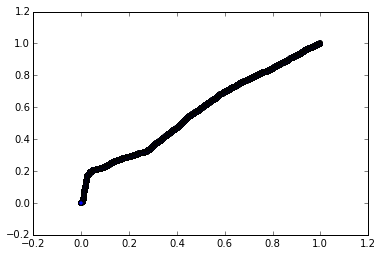

In [315]:
i = 0
plt.scatter(auc_pairs_list[i].fpr, auc_pairs_list[i].tpr)

In [460]:
re

<module 're' from '/Users/feizhan/miniconda/envs/py3_env/lib/python3.4/re.py'>

In [462]:
df = pd.DataFrame(np.array([[1, 1], [2, 10], [3, 100], [4, 100]]),
                  columns=['a', 'b'])

In [463]:
df

,a,b
0,1,1
1,2,10
2,3,100
3,4,100


In [464]:
df.quantile(0.1)

a    1.3
b    3.7
dtype: float64

In [465]:
df.quantile(0.1, axis=1)

0     1.0
1     2.8
2    12.7
3    13.6
dtype: float64

In [466]:
df['a'].quantile()

2.5

In [ ]:
pd.to_datetime(infer_datetime_format=